In [1]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score
)                           
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# read in all datasets
attendance_pri = pd.read_csv("data/primary/attendance.csv")
attendance_lsec = pd.read_csv("data/lower_secondary/attendance.csv")
attendance_usec = pd.read_csv("data/upper_secondary/attendance.csv")

completion_rate_pri = pd.read_csv("data/primary/completion-rate.csv")
completion_rate_lsec = pd.read_csv("data/lower_secondary/completion-rate.csv")
completion_rate_usec = pd.read_csv("data/upper_secondary/completion-rate.csv")

connectivity_pri = pd.read_csv("data/primary/connectivity.csv")
connectivity_lsec = pd.read_csv("data/lower_secondary/connectivity.csv")
connectivity_usec = pd.read_csv("data/upper_secondary/connectivity.csv")

out_of_school_pri = pd.read_csv("data/primary/out-of-school.csv")
out_of_school_lsec = pd.read_csv("data/lower_secondary/out-of-school.csv")
out_of_school_usec = pd.read_csv("data/upper_secondary/out-of-school.csv")

In [3]:
# do some cleaning to make it easier to merge
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# double checking dimensions
print(attendance_pri.shape)
print(completion_rate_pri.shape)
print(connectivity_pri.shape)
print(out_of_school_pri.shape)

print(attendance_lsec.shape)
print(completion_rate_lsec.shape)
print(connectivity_lsec.shape)
print(out_of_school_lsec.shape)

print(attendance_usec.shape)
print(completion_rate_usec.shape)
print(connectivity_usec.shape)
print(out_of_school_usec.shape)

# dropping columns that we don't need
oos_keep = ['ISO3', 'Countries and areas', 'Region', 'Sub-region', 'Development Regions', 'Total', 
            'Female', 'Male', 'Rural', 'Urban', 'Poorest', 'Second', 'Middle', 'Fourth', 'Richest']

attendance_pri = attendance_pri.drop(["Data source", "Time period"], axis = 1)
attendance_lsec = attendance_lsec.drop(["Data source", "Time period"], axis = 1)
attendance_usec = attendance_usec.drop(["Data source", "Time period"], axis = 1)

completion_rate_pri = completion_rate_pri.drop(["Data source", "Time period"], axis = 1)
completion_rate_lsec = completion_rate_lsec.drop(["Data source", "Time period"], axis = 1)
completion_rate_usec = completion_rate_usec.drop(["Data source", "Time period"], axis = 1)

connectivity_pri = connectivity_pri.drop(["Data source", "Time period"], axis = 1)
connectivity_lsec = connectivity_lsec.drop(["Data source", "Time period"], axis = 1)
connectivity_usec = connectivity_usec.drop(["Data source", "Time period"], axis = 1)

out_of_school_pri = out_of_school_pri[oos_keep]
out_of_school_lsec = out_of_school_lsec[oos_keep]
out_of_school_usec = out_of_school_usec[oos_keep]

(202, 17)
(202, 17)
(87, 12)
(202, 23)
(202, 17)
(202, 17)
(87, 12)
(202, 23)
(202, 17)
(202, 17)
(82, 12)
(202, 23)


In [4]:
# rename columns (prepend labels to columns) and prepare them for merge
# oos = out of school, comp = completion, con = connectivity, att = attendance
to_rename = ["Total", "Female", "Male", "Rural", "Urban", "Poorest", "Second", "Middle", "Fourth", "Richest"]

attendance_pri = attendance_pri.rename(lambda col: 'att_'+col if col in to_rename else col, axis='columns')
attendance_lsec = attendance_lsec.rename(lambda col: 'att_'+col if col in to_rename else col, axis='columns')
attendance_usec = attendance_usec.rename(lambda col: 'att_'+col if col in to_rename else col, axis='columns')

completion_rate_pri = completion_rate_pri.rename(lambda col: 'comp_'+col if col in to_rename else col, axis='columns')
completion_rate_lsec = completion_rate_lsec.rename(lambda col: 'comp_'+col if col in to_rename else col, axis='columns')
completion_rate_usec = completion_rate_usec.rename(lambda col: 'comp_'+col if col in to_rename else col, axis='columns')

connectivity_pri = connectivity_pri.rename(lambda col: 'con_'+col if col in to_rename else col, axis='columns')
connectivity_lsec = connectivity_lsec.rename(lambda col: 'con_'+col if col in to_rename else col, axis='columns')
connectivity_usec = connectivity_usec.rename(lambda col: 'con_'+col if col in to_rename else col, axis='columns')

# clean connectivity data
# this is because some numeric data have "%" and it is not recognized as a float type
for col in ['Total', 'Urban', 'Rural', 'Poorest', 'Richest']:
    connectivity_pri['con_'+col] = connectivity_pri['con_'+col].map(lambda x: x.rstrip('%') if not pd.isnull(x) else x).astype(float)
    connectivity_lsec['con_'+col] = connectivity_lsec['con_'+col].map(lambda x: x.rstrip('%') if not pd.isnull(x) else x).astype(float)
    connectivity_usec['con_'+col] = connectivity_usec['con_'+col].map(lambda x: x.rstrip('%') if not pd.isnull(x) else x).astype(float)

out_of_school_pri = out_of_school_pri.rename(lambda col: 'oos_'+col if col in to_rename else col, axis='columns')
out_of_school_lsec = out_of_school_lsec.rename(lambda col: 'oos_'+col if col in to_rename else col, axis='columns')
out_of_school_usec = out_of_school_usec.rename(lambda col: 'oos_'+col if col in to_rename else col, axis='columns')

In [5]:
df_primary = [connectivity_pri, attendance_pri, out_of_school_pri, completion_rate_pri]
df_lower_secondary = [connectivity_lsec, attendance_lsec, out_of_school_lsec, completion_rate_lsec]
df_upper_secondary = [connectivity_usec, attendance_usec, out_of_school_usec, completion_rate_usec]

# merge the data by education level
primary = reduce(lambda  left,right: pd.merge(left,right,on=['ISO3'], how='right'), df_primary)
lower_secondary = reduce(lambda  left,right: pd.merge(left,right,on=['ISO3'], how='right'), df_lower_secondary)
upper_secondary = reduce(lambda  left,right: pd.merge(left,right,on=['ISO3'], how='right'), df_upper_secondary)

In [6]:
# reading in demographic datasets
demographic = pd.read_csv("data/demographics/demographic.csv")
gdp = pd.read_csv('data/demographics/gdp.csv')

In [7]:
# drop any observations that are not in 2019
cleaned_fertility = demographic.copy()
cleaned_life_expectancy = demographic.copy()
cleaned_mortality_rate = demographic.copy()
cleaned_pop_growth = demographic.copy()
cleaned_rural_pop = demographic.copy()
cleaned_total_pop = demographic.copy()
cleaned_gdp = gdp.copy()

cleaned_fertility = cleaned_fertility[cleaned_fertility['Time'] == 2019]
cleaned_fertility = cleaned_fertility[cleaned_fertility['Indicator'] == 'Fertility rate, total (births per woman)']
cleaned_fertility = cleaned_fertility[['Country', 'LOCATION', 'Value']]

cleaned_gdp = cleaned_gdp[cleaned_gdp['Time'] == 2019]
cleaned_gdp = cleaned_gdp[cleaned_gdp['Indicator'] == "GDP (current LCU)"]
cleaned_gdp = cleaned_gdp[['Country', 'LOCATION', 'Value']]

cleaned_life_expectancy = cleaned_life_expectancy[cleaned_life_expectancy['Time'] == 2019]
cleaned_life_expectancy = cleaned_life_expectancy[cleaned_life_expectancy['Indicator'] == 'Life expectancy at birth, total (years)']
cleaned_life_expectancy = cleaned_life_expectancy[['Country', 'LOCATION', 'Value']]

cleaned_mortality_rate = cleaned_mortality_rate[cleaned_mortality_rate['Time'] == 2019]
cleaned_mortality_rate = cleaned_mortality_rate[cleaned_mortality_rate['Indicator'] == 'Mortality rate, infant (per 1,000 live births)']
cleaned_mortality_rate = cleaned_mortality_rate[['Country', 'LOCATION', 'Value']]

cleaned_pop_growth = cleaned_pop_growth[cleaned_pop_growth['Time'] == 2019]
cleaned_pop_growth = cleaned_pop_growth[cleaned_pop_growth['Indicator'] == 'Population growth (annual %)']
cleaned_pop_growth = cleaned_pop_growth[['Country', 'LOCATION', 'Value']]

cleaned_rural_pop = cleaned_rural_pop[cleaned_rural_pop['Time'] == 2019]
cleaned_rural_pop = cleaned_rural_pop[cleaned_rural_pop['Indicator'] == 'Rural population (% of total population)']
cleaned_rural_pop = cleaned_rural_pop[['Country', 'LOCATION', 'Value']]

cleaned_total_pop = cleaned_total_pop[cleaned_total_pop['Time'] == 2019]
cleaned_total_pop = cleaned_total_pop[cleaned_total_pop['Indicator'] == 'Total population (thousands)']
cleaned_total_pop = cleaned_total_pop[['Country', 'LOCATION', 'Value']]

# rename some columns
cleaned_fertility = cleaned_fertility.rename(lambda col: 'fertility' if col =='Value' else col, axis='columns')
cleaned_gdp = cleaned_gdp.rename(lambda col: 'gdp' if col =='Value' else col, axis='columns')
cleaned_life_expectancy = cleaned_life_expectancy.rename(lambda col: 'life expectancy' if col =='Value' else col, axis='columns')
cleaned_mortality_rate = cleaned_mortality_rate.rename(lambda col: 'mortality rate' if col =='Value' else col, axis='columns')
cleaned_pop_growth = cleaned_pop_growth.rename(lambda col: 'pop growth' if col =='Value' else col, axis='columns')
cleaned_rural_pop = cleaned_rural_pop.rename(lambda col: 'rural pop' if col =='Value' else col, axis='columns')
cleaned_total_pop = cleaned_total_pop.rename(lambda col: 'total pop' if col =='Value' else col, axis='columns')

df_demographics = [cleaned_fertility, cleaned_gdp, cleaned_life_expectancy, cleaned_mortality_rate, cleaned_pop_growth, cleaned_rural_pop, cleaned_total_pop]

# merge demographics data
demographics_merged = reduce(lambda  left,right: pd.merge(left,right,on=['LOCATION'], how='outer'), df_demographics)

In [8]:
primary_with_demographics = primary.merge(demographics_merged, left_on = 'ISO3', right_on = 'LOCATION')
lower_secondary_with_demographics = lower_secondary.merge(demographics_merged, left_on = 'ISO3', right_on = 'LOCATION')
upper_secondary_with_demographics = upper_secondary.merge(demographics_merged, left_on = 'ISO3', right_on = 'LOCATION')

In [9]:
predictors_knn = ['fertility', 'gdp', 'life expectancy', 'mortality rate', 'pop growth', 'rural pop', 'total pop']

In [10]:
# interestingly, USA and Canada have no data at all, so we're dropping them
primary_with_demographics = primary_with_demographics.loc[:,~primary_with_demographics.columns.duplicated()]
primary_with_demographics = primary_with_demographics.dropna(subset=['Region_x'])

lower_secondary_with_demographics = lower_secondary_with_demographics.loc[:,~lower_secondary_with_demographics.columns.duplicated()]
lower_secondary_with_demographics = lower_secondary_with_demographics.dropna(subset=['Region_x'])

upper_secondary_with_demographics = upper_secondary_with_demographics.loc[:,~upper_secondary_with_demographics.columns.duplicated()]
upper_secondary_with_demographics = upper_secondary_with_demographics.dropna(subset=['Region_x'])

# perform train test split, stratified by geographic region
primary_train, primary_test = train_test_split(primary_with_demographics, test_size=0.2, random_state=50, stratify=primary_with_demographics['Region_x'])

lower_secondary_train, lower_secondary_test = train_test_split(lower_secondary_with_demographics, test_size=0.2, random_state=50, stratify=lower_secondary_with_demographics['Region_x'])

upper_secondary_train, upper_secondary_test = train_test_split(upper_secondary_with_demographics, test_size=0.2, random_state=50, stratify=upper_secondary_with_demographics['Region_x'])

In [11]:
# impute data using KNNImputer
def impute_data(data):
    imputed = data.copy()
    numeric_columns = data.select_dtypes(include='number').columns
    imp = KNNImputer(missing_values = np.nan, n_neighbors=3)
    imputed[numeric_columns] = imp.fit_transform(imputed[numeric_columns])
    return imputed

# impute on the training data
pri_train_imputed = impute_data(primary_train)
lsec_train_imputed = impute_data(lower_secondary_train)
usec_train_imputed = impute_data(upper_secondary_train)

pri_test_imputed = impute_data(primary_test)
lsec_test_imputed = impute_data(lower_secondary_test)
usec_test_imputed = impute_data(upper_secondary_test)

In [12]:
# one-hot-encoding for categorical variables
pri_train_encoded = pri_train_imputed.copy()
lsec_train_encoded = lsec_train_imputed.copy()
usec_train_encoded = usec_train_imputed.copy()

pri_test_encoded = pri_test_imputed.copy()
lsec_test_encoded = lsec_test_imputed.copy()
usec_test_encoded = usec_test_imputed.copy()

categorical_vars = ['Region_x', 'Income Group', 'Development Regions_x']

pri_train_encoded = pd.get_dummies(pri_train_encoded, columns = categorical_vars)
lsec_train_encoded = pd.get_dummies(lsec_train_encoded, columns = categorical_vars)
usec_train_encoded = pd.get_dummies(usec_train_encoded, columns = categorical_vars)

pri_test_encoded = pd.get_dummies(pri_test_encoded, columns = categorical_vars)
lsec_test_encoded = pd.get_dummies(lsec_test_encoded, columns = categorical_vars)
usec_test_encoded = pd.get_dummies(usec_test_encoded, columns = categorical_vars)

Text(0.5, -0.2, 'Out-of-School Rate')

Text(0.5, -0.2, 'Completion Rate')

Text(0.5, -0.2, 'Attendance Rate')

Text(0.5, 1.1, 'Outcomes vs. Connectivity (Primary)')

Text(0.5, -0.2, 'Out-of-School Rate')

Text(0.5, -0.2, 'Completion Rate')

Text(0.5, -0.2, 'Attendance Rate')

Text(0.5, 1.1, 'Outcomes vs. Connectivity (Lower Secondary)')

Text(0.5, -0.2, 'Out-of-School Rate')

Text(0.5, -0.2, 'Completion Rate')

Text(0.5, -0.2, 'Attendance Rate')

Text(0.5, 1.1, 'Outcomes vs. Connectivity (Upper Secondary)')

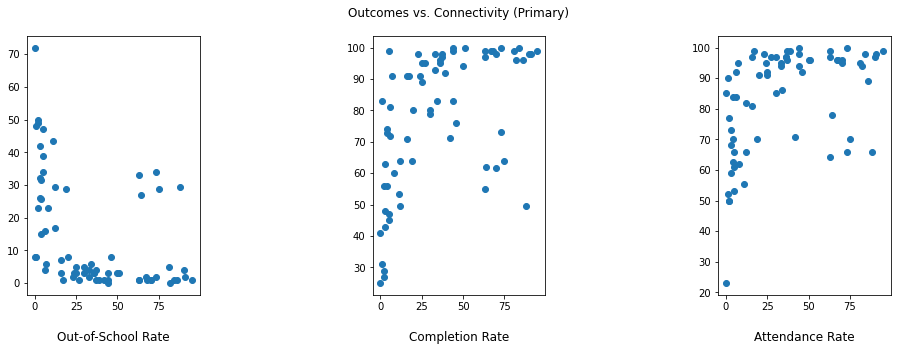

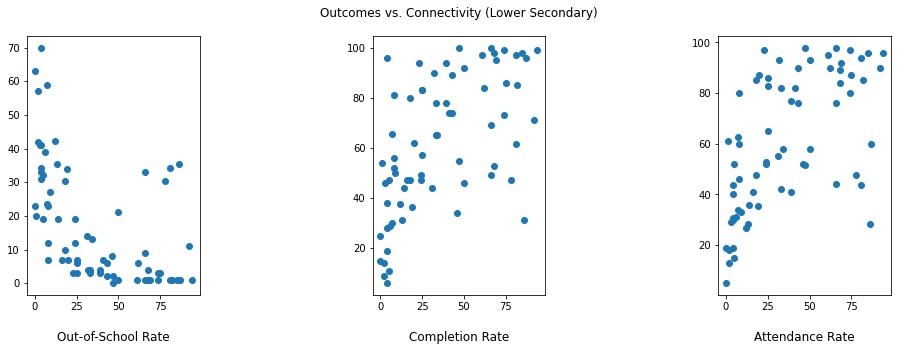

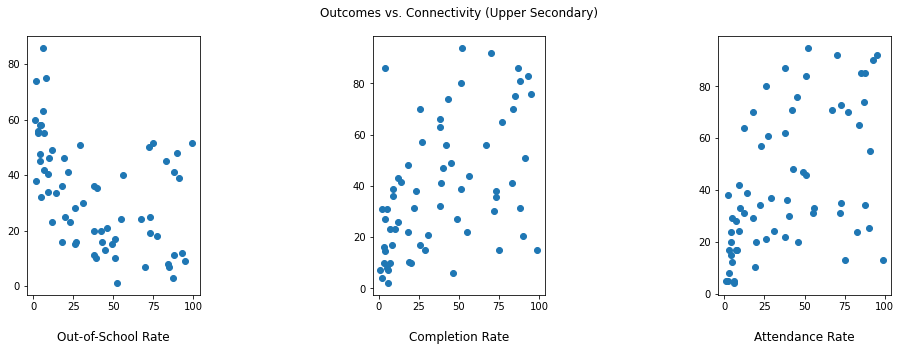

In [13]:
# making scatterplots of three outcomes (attendance, out-of-school, completion) vs. connectivity
outcome_list = ['oos_Total', 'comp_Total', 'att_Total']
outcomes_name = {'oos_Total': 'Out-of-School Rate', 'comp_Total': 'Completion Rate', 'att_Total': 'Attendance Rate'}

name_dict = {'Primary': pri_train_encoded, 'Lower Secondary': lsec_train_encoded, 'Upper Secondary': usec_train_encoded}

for item in name_dict:
    levels = name_dict[item]
    fig, axes = plt.subplots(1, 3, figsize = (15, 4));
    for outcome, ax in zip(outcome_list, axes.flatten()):
        ax.scatter(levels['con_Total'], levels[outcome]);
        ax.set_title(outcomes_name[outcome], y=-0.2);
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=1, hspace=0.5);
    fig.suptitle('Outcomes vs. Connectivity (' + item + ')', x=0.5, y=1.1);

In [14]:
# linear relationships, with total connectivity as the single predictor
data_dict = {'primary ': [pri_train_encoded, pri_test_encoded], 
             'lower secondary ': [lsec_train_encoded, lsec_test_encoded], 
             'upper secondary ': [usec_train_encoded, lsec_test_encoded]}

response_dict = {'out of school proportion': 'oos_Total', 'completion rate': 'comp_Total', 'attendance': 'att_Total'}

titles_dict = {'primary out of school proportion': 'pri oos', 'primary completion rate': 'pri comp', 'primary attendance': 'pri att',
               'lower secondary out of school proportion': 'lsec oos', 'lower secondary completion rate': 'lsec comp', 'lower secondary attendance': 'lsec att',
               'upper secondary out of school proportion': 'usec oos', 'upper secondary completion rate': 'usec comp', 'upper secondary attendance': 'usec att'}

results_one_pred_dict = {}
mse_train_one_pred = {}
mse_test_one_pred = {}
one_pred_predictions = []

for name in data_dict:
    data_train = data_dict[name][0]
    data_test = data_dict[name][1]
    for name_response in response_dict:
        response = response_dict[name_response]
        X_train, y_train = data_train[['con_Total']], data_train[[response]]
        X_test, y_test = data_test[['con_Total']], data_test[[response]]
        mse_title = titles_dict[name + name_response]
        model = LinearRegression();
        model.fit(X_train, y_train)
        mse_train_one_pred[mse_title] = mean_squared_error(y_train, model.predict(X_train))
        mse_test_one_pred[mse_title] = mean_squared_error(y_test, model.predict(X_test))
        results_one_pred_dict[name + name_response + ' coefficient'] = model.coef_[0][0]
        results_one_pred_dict[name + name_response + ' intercept'] = model.intercept_[0]
        results_one_pred_dict[name + name_response + ' train mse'] = mean_squared_error(y_train, model.predict(X_train))
        results_one_pred_dict[name + name_response + ' test mse'] = mean_squared_error(y_test, model.predict(X_test))
        # keep track of predictions so we can plot them
        y_pred = model.predict(X_test)
        one_pred_predictions.append((X_test, y_pred))

print("The results for linear regressions involving one predictor are") 
results_one_pred_dict

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

The results for linear regressions involving one predictor are


{'primary out of school proportion coefficient': -0.2638401152194592,
 'primary out of school proportion intercept': 23.44634995144859,
 'primary out of school proportion train mse': 219.80077658299615,
 'primary out of school proportion test mse': 85.68783220324357,
 'primary completion rate coefficient': 0.38621362225126415,
 'primary completion rate intercept': 63.9831048009096,
 'primary completion rate train mse': 346.7121092564269,
 'primary completion rate test mse': 349.8104685060595,
 'primary attendance coefficient': 0.2697082667788832,
 'primary attendance intercept': 73.9218682859031,
 'primary attendance train mse': 221.65660542667044,
 'primary attendance test mse': 117.15304282596256,
 'lower secondary out of school proportion coefficient': -0.3254735612071059,
 'lower secondary out of school proportion intercept': 29.180132860952085,
 'lower secondary out of school proportion train mse': 212.718192986752,
 'lower secondary out of school proportion test mse': 97.96108565

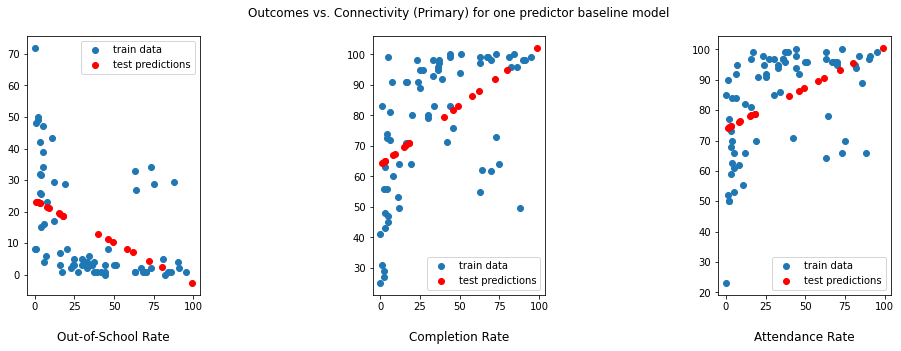

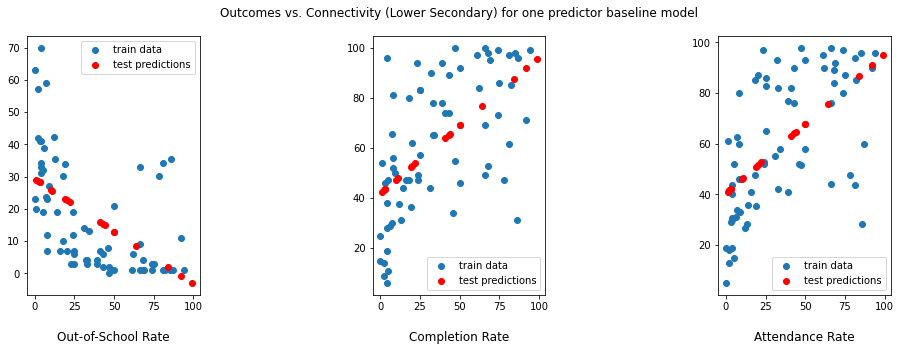

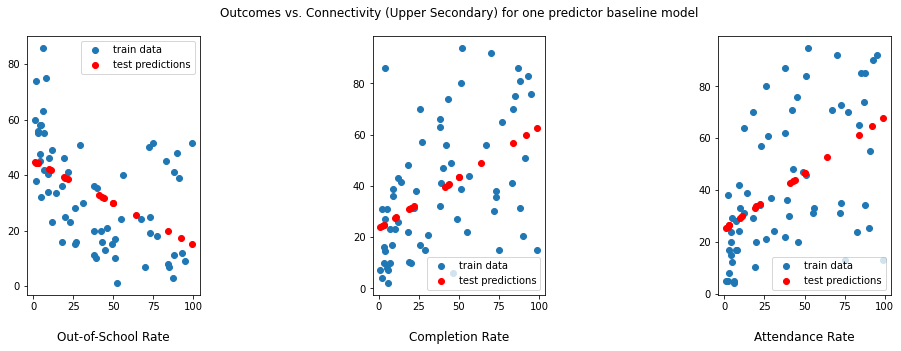

In [15]:
def plot_predictions(title, pred):
    # pred is an array of (X_test, y_pred)
    # should be ordered by oos, comp, and att
    # this function plots scatter plots for predictions
    i = 0
    for item in name_dict:
        levels = name_dict[item]
        fig, axes = plt.subplots(1, 3, figsize = (15, 4));
        for outcome, ax in zip(outcome_list, axes.flatten()):
            ax.scatter(levels['con_Total'], levels[outcome], label='train data');
            # sort the data
            ax.scatter(pred[i][0], pred[i][1], color="red", label='test predictions')
            ax.set_title(outcomes_name[outcome], y=-0.2);
            ax.legend()
            i += 1
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=1, hspace=0.5);
        fig.suptitle('Outcomes vs. Connectivity (' + item + ') for ' + title, x=0.5, y=1.1);

plot_predictions("one predictor baseline model", one_pred_predictions)

In [16]:
# linear relationships, with two predictors: total connectivity and development region
results_two_preds_dict = {}
two_preds_predictions = []
mse_train_two_preds = {}
mse_test_two_preds = {}

for name in data_dict:
    data_train = data_dict[name][0]
    data_test = data_dict[name][1]
    for name_response in response_dict:
        response = response_dict[name_response]
        X_train, y_train = data_train[['con_Total', 'Development Regions_x_Less Developed']], data_train[[response]]
        X_test, y_test = data_test[['con_Total', 'Development Regions_x_Less Developed']], data_test[[response]]
        model = LinearRegression();
        model.fit(X_train, y_train);
        mse_title = titles_dict[name + name_response]
        mse_train_two_preds[mse_title] = mean_squared_error(y_train, model.predict(X_train))
        mse_test_two_preds[mse_title] = mean_squared_error(y_test, model.predict(X_test))
        results_two_preds_dict[name + name_response + ' coefficients'] = model.coef_[0]
        results_two_preds_dict[name + name_response + ' intercept'] = model.intercept_[0]
        results_two_preds_dict[name + name_response + ' MSE'] = mean_squared_error(y_train, model.predict(X_train))
        y_pred = model.predict(X_test)
        two_preds_predictions.append((X_test['con_Total'], y_pred))
        results_two_preds_dict[name + name_response + ' MSE'] = mean_squared_error(y_test, y_pred)

print("The results for linear regressions involving two predictors are") 
results_two_preds_dict

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

The results for linear regressions involving two predictors are


{'primary out of school proportion coefficients': array([ -0.23503178, -15.18932982]),
 'primary out of school proportion intercept': 31.23720412857321,
 'primary out of school proportion MSE': 80.0711281132996,
 'primary completion rate coefficients': array([ 0.34668697, 20.8406127 ]),
 'primary completion rate intercept': 53.29361577039434,
 'primary completion rate MSE': 208.59033130341933,
 'primary attendance coefficients': array([ 0.24436344, 13.36318   ]),
 'primary attendance intercept': 67.06767603918479,
 'primary attendance MSE': 72.82756139866582,
 'lower secondary out of school proportion coefficients': array([ -0.27077154, -16.34427101]),
 'lower secondary out of school proportion intercept': 37.39166372700271,
 'lower secondary out of school proportion MSE': 171.21259164781858,
 'lower secondary completion rate coefficients': array([ 0.46228599, 23.4495714 ]),
 'lower secondary completion rate intercept': 30.109801573201747,
 'lower secondary completion rate MSE': 409.21

In [17]:
preds_oos = ['con_Total', 'con_Rural', 'con_Urban', 'con_Poorest', 'con_Richest',
             'att_Total', 'att_Female', 'att_Male', 'att_Rural', 'att_Urban', 'att_Poorest', 'att_Second', 'att_Middle', 'att_Fourth', 'att_Richest', 
             'comp_Total', 'comp_Female', 'comp_Male', 'comp_Rural', 'comp_Urban', 'comp_Poorest', 'comp_Second', 'comp_Middle', 'comp_Fourth', 'comp_Richest', 
             'fertility', 'gdp', 'life expectancy', 'mortality rate', 'pop growth', 'rural pop', 'total pop', 
             'Region_x_EAP', 'Region_x_ECA', 'Region_x_LAC','Region_x_MENA', 'Region_x_SA', 'Region_x_SSA',
             'Income Group_High income (H)', 'Income Group_Low income (L)', 'Income Group_Lower middle income (LM)', 'Income Group_Upper middle income (UM)',
             'Development Regions_x_Least Developed', 'Development Regions_x_Less Developed', 'Development Regions_x_More Developed']

preds_att = ['con_Total', 'con_Rural', 'con_Urban', 'con_Poorest', 'con_Richest',
             'oos_Total', 'oos_Female', 'oos_Male', 'oos_Rural', 'oos_Urban', 'oos_Poorest', 'oos_Second', 'oos_Middle', 'oos_Fourth', 'oos_Richest', 
             'comp_Total', 'comp_Female', 'comp_Male', 'comp_Rural', 'comp_Urban', 'comp_Poorest', 'comp_Second', 'comp_Middle', 'comp_Fourth', 'comp_Richest', 
             'fertility', 'gdp', 'life expectancy', 'mortality rate', 'pop growth', 'rural pop', 'total pop', 
             'Region_x_EAP', 'Region_x_ECA', 'Region_x_LAC','Region_x_MENA', 'Region_x_SA', 'Region_x_SSA',
             'Income Group_High income (H)', 'Income Group_Low income (L)', 'Income Group_Lower middle income (LM)', 'Income Group_Upper middle income (UM)',
             'Development Regions_x_Least Developed', 'Development Regions_x_Less Developed', 'Development Regions_x_More Developed']

preds_comp = ['con_Total', 'con_Rural', 'con_Urban', 'con_Poorest', 'con_Richest',
              'att_Total', 'att_Female', 'att_Male', 'att_Rural', 'att_Urban', 'att_Poorest', 'att_Second', 'att_Middle', 'att_Fourth', 'att_Richest',
              'oos_Total', 'oos_Female', 'oos_Male', 'oos_Rural', 'oos_Urban', 'oos_Poorest', 'oos_Second', 'oos_Middle', 'oos_Fourth', 'oos_Richest', 
              'fertility', 'gdp', 'life expectancy', 'mortality rate', 'pop growth', 'rural pop', 'total pop', 
              'Region_x_EAP', 'Region_x_ECA', 'Region_x_LAC','Region_x_MENA', 'Region_x_SA', 'Region_x_SSA',
              'Income Group_High income (H)', 'Income Group_Low income (L)', 'Income Group_Lower middle income (LM)', 'Income Group_Upper middle income (UM)',
              'Development Regions_x_Least Developed', 'Development Regions_x_Less Developed', 'Development Regions_x_More Developed']

In [18]:
def mse_plot(
    var_list,
    train_score,
    val_score,
    val_std=None,
    title=None,
    x_label=None,
    loc="best",
    log_mse=False,
    log_xscale=False,
):
    """Generate plot for train and validation MSE values
    
    This function generates a train and validation MSE plot with
    options to add +/-1 standard deviation validation bounds, and
    to log scale either axis to improve plot interpretability
    if needed.
    
    :param var_list: list or array, values for x-axis tick labels 
    :param train_score: list or array, training mse values
    :param val_score: list or array, validation mse values
    :param val_std: list or array, validation std mse values used
                    to plot +/-1 standard deviation bounds
                    (optional, default is None)
    :param title: str, plot title (optional, default is None)
    :param x_label: str, x-axis label (optional, default is None)
    :param loc: int or "best", specifies position of legend
                (optional, default is "best")
    :param log_mse: bool, whether or not to log-scale MSE values
                    (optional, default is False)
    :param log_xscale: bool, whether or not to log-scale x-axis value
                       (optional, default is False)
    """
    fig, ax = plt.subplots(figsize=(9, 5))
    
    # Plot train and validation MSE values as lineplots
    ax.plot(
        var_list,
        train_score,
        "o--",
        label="Training",
        linewidth=2,
        alpha=0.4,
    )
    ax.plot(
        var_list,
        val_score,
        "^-",
        label="Validation",
        markeredgecolor="k",
        linewidth=2,
        alpha=0.7,
    )

    # Plot +/-1 standard deviation validation MSE bounds
    # Values are clipped at MSE=0 lower bound to keep values
    # within realm of reasonable MSE values (i.e. MSE cannot
    # realistically be negative)
    if val_std is not None:
        ax.fill_between(
            var_list, 
            np.clip(
                np.array(val_score)-val_std, a_min=0, a_max=None
            ),
            np.array(val_score)+val_std,
            color="tab:orange",
            alpha=0.2,
            label = "Validation +/-1 standard deviation")

    # Plot x-axis in log-scale if specified, this option is used in
    # Q6 to provide a more easily read set of alpha value ticks
    if log_xscale:
        ax.set_xscale("log")
    
    # Plot y-axis (i.e. MSE) in log-scale if specified, this option is
    # used in Q4 in an attempt to make MSE lines easier to see
    if log_mse:
        ax.set_yscale("log")
        ax.set_ylabel("$MSE$ (log scaled)", fontsize=12)
    else:
        ax.set_ylabel("$MSE$", fontsize=12)

        
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_title(title, fontsize= 14)
    ax.legend(loc=loc, fontsize =12)
    ax.set_xticks(var_list)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [19]:
# we will be using all of the predictors we can use to train a RandomForestRegressor and we will find the most significant predictors

all_preds = {"completion rate": preds_comp, "out of school proportion": preds_oos, "attendance": preds_att}

features_used = ['con_Total', 'con_Rural', 'con_Urban', 'con_Poorest', 'con_Richest',
                 'att_Total', 'att_Female', 'att_Male', 'att_Rural', 'att_Urban', 'att_Poorest', 'att_Second', 'att_Middle', 'att_Fourth', 'att_Richest',
                 'oos_Total', 'oos_Female', 'oos_Male', 'oos_Rural', 'oos_Urban', 'oos_Poorest', 'oos_Second', 'oos_Middle', 'oos_Fourth', 'oos_Richest', 
                 'comp_Total', 'comp_Female', 'comp_Male', 'comp_Rural', 'comp_Urban', 'comp_Poorest', 'comp_Second', 'comp_Middle', 'comp_Fourth', 'comp_Richest', 
                 'fertility', 'gdp', 'life expectancy', 'mortality rate', 'pop growth', 'rural pop', 'total pop', 
                 'Region_x_EAP', 'Region_x_ECA', 'Region_x_LAC','Region_x_MENA', 'Region_x_SA', 'Region_x_SSA',
                 'Income Group_High income (H)', 'Income Group_Low income (L)', 'Income Group_Lower middle income (LM)', 'Income Group_Upper middle income (UM)',
                 'Development Regions_x_Least Developed', 'Development Regions_x_Less Developed', 'Development Regions_x_More Developed']

# keep track of the number of times a feature/predictor has been declared the most significant or important
top_features_oos = {x : 0 for x in features_used}
top_features_comp = {x : 0 for x in features_used}
top_features_att = {x : 0 for x in features_used}
top_features = {"completion rate": top_features_comp, "out of school proportion": top_features_oos, "attendance": top_features_att}

for name in data_dict:
    data_train = data_dict[name][0]
    data_test = data_dict[name][1]
    for name_response in response_dict:
        response = response_dict[name_response]
        # get the specific list of predictors depending on response
        features_used = all_preds[name_response]
        X_train, y_train = data_train[features_used], data_train[response]
        X_test, y_test = data_test[features_used], data_test[response]
        model = RandomForestRegressor(max_depth=5, random_state=0);
        fit = model.fit(X_train, y_train);

        # keep track of how often a feature is considered important
        for feature, importance in zip(features_used, model.feature_importances_):
            if importance > 0:
                top_features[name_response][feature] += importance

number_of_top_features = 10
print("The top features for each response variable:")
top_features

The top features for each response variable:


{'completion rate': {'con_Total': 0.020500109954412336,
  'con_Rural': 0.015562307237060046,
  'con_Urban': 0.010706656918729879,
  'con_Poorest': 0.010443015929781472,
  'con_Richest': 0.06392861829752469,
  'att_Total': 0.22040318025030747,
  'att_Female': 0.6340649822977404,
  'att_Male': 0.1761607273522441,
  'att_Rural': 0.32240880146899487,
  'att_Urban': 0.061167662697436155,
  'att_Poorest': 0.23554107429776633,
  'att_Second': 0.08925029161713058,
  'att_Middle': 0.11069727103400849,
  'att_Fourth': 0.056514902210617,
  'att_Richest': 0.03460377149241298,
  'oos_Total': 0.05844243772831091,
  'oos_Female': 0.08307394440662684,
  'oos_Male': 0.20562332784135112,
  'oos_Rural': 0.08906715266921685,
  'oos_Urban': 0.02088226619791037,
  'oos_Poorest': 0.04560834007745303,
  'oos_Second': 0.027769927227133517,
  'oos_Middle': 0.005134435229886926,
  'oos_Fourth': 0.013053425835654997,
  'oos_Richest': 0.038748803431961173,
  'comp_Total': 0,
  'comp_Female': 0,
  'comp_Male': 0,
 

<BarContainer object of 55 artists>

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Cumulative feature importance')

([<matplotlib.axis.XTick at 0x7fd9283934f0>,
 [Text(0, 0, 'con_Total'),
  Text(1, 0, 'con_Rural'),
  Text(2, 0, 'con_Urban'),
  Text(3, 0, 'con_Poorest'),
  Text(4, 0, 'con_Richest'),
  Text(5, 0, 'att_Total'),
  Text(6, 0, 'att_Female'),
  Text(7, 0, 'att_Male'),
  Text(8, 0, 'att_Rural'),
  Text(9, 0, 'att_Urban'),
  Text(10, 0, 'att_Poorest'),
  Text(11, 0, 'att_Second'),
  Text(12, 0, 'att_Middle'),
  Text(13, 0, 'att_Fourth'),
  Text(14, 0, 'att_Richest'),
  Text(15, 0, 'oos_Total'),
  Text(16, 0, 'oos_Female'),
  Text(17, 0, 'oos_Male'),
  Text(18, 0, 'oos_Rural'),
  Text(19, 0, 'oos_Urban'),
  Text(20, 0, 'oos_Poorest'),
  Text(21, 0, 'oos_Second'),
  Text(22, 0, 'oos_Middle'),
  Text(23, 0, 'oos_Fourth'),
  Text(24, 0, 'oos_Richest'),
  Text(25, 0, 'comp_Total'),
  Text(26, 0, 'comp_Female'),
  Text(27, 0, 'comp_Male'),
  Text(28, 0, 'comp_Rural'),
  Text(29, 0, 'comp_Urban'),
  Text(30, 0, 'comp_Poorest'),
  Text(31, 0, 'comp_Second'),
  Text(32, 0, 'comp_Middle'),
  Text(33, 

Text(0.5, 1.0, 'Cumulative feature importance score of all features for completion rate')

<BarContainer object of 55 artists>

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Cumulative feature importance')

([<matplotlib.axis.XTick at 0x7fd92862ceb0>,
 [Text(0, 0, 'con_Total'),
  Text(1, 0, 'con_Rural'),
  Text(2, 0, 'con_Urban'),
  Text(3, 0, 'con_Poorest'),
  Text(4, 0, 'con_Richest'),
  Text(5, 0, 'att_Total'),
  Text(6, 0, 'att_Female'),
  Text(7, 0, 'att_Male'),
  Text(8, 0, 'att_Rural'),
  Text(9, 0, 'att_Urban'),
  Text(10, 0, 'att_Poorest'),
  Text(11, 0, 'att_Second'),
  Text(12, 0, 'att_Middle'),
  Text(13, 0, 'att_Fourth'),
  Text(14, 0, 'att_Richest'),
  Text(15, 0, 'oos_Total'),
  Text(16, 0, 'oos_Female'),
  Text(17, 0, 'oos_Male'),
  Text(18, 0, 'oos_Rural'),
  Text(19, 0, 'oos_Urban'),
  Text(20, 0, 'oos_Poorest'),
  Text(21, 0, 'oos_Second'),
  Text(22, 0, 'oos_Middle'),
  Text(23, 0, 'oos_Fourth'),
  Text(24, 0, 'oos_Richest'),
  Text(25, 0, 'comp_Total'),
  Text(26, 0, 'comp_Female'),
  Text(27, 0, 'comp_Male'),
  Text(28, 0, 'comp_Rural'),
  Text(29, 0, 'comp_Urban'),
  Text(30, 0, 'comp_Poorest'),
  Text(31, 0, 'comp_Second'),
  Text(32, 0, 'comp_Middle'),
  Text(33, 

Text(0.5, 1.0, 'Cumulative feature importance score of all features for out of school proportion')

<BarContainer object of 55 artists>

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Cumulative feature importance')

([<matplotlib.axis.XTick at 0x7fd91c466100>,
 [Text(0, 0, 'con_Total'),
  Text(1, 0, 'con_Rural'),
  Text(2, 0, 'con_Urban'),
  Text(3, 0, 'con_Poorest'),
  Text(4, 0, 'con_Richest'),
  Text(5, 0, 'att_Total'),
  Text(6, 0, 'att_Female'),
  Text(7, 0, 'att_Male'),
  Text(8, 0, 'att_Rural'),
  Text(9, 0, 'att_Urban'),
  Text(10, 0, 'att_Poorest'),
  Text(11, 0, 'att_Second'),
  Text(12, 0, 'att_Middle'),
  Text(13, 0, 'att_Fourth'),
  Text(14, 0, 'att_Richest'),
  Text(15, 0, 'oos_Total'),
  Text(16, 0, 'oos_Female'),
  Text(17, 0, 'oos_Male'),
  Text(18, 0, 'oos_Rural'),
  Text(19, 0, 'oos_Urban'),
  Text(20, 0, 'oos_Poorest'),
  Text(21, 0, 'oos_Second'),
  Text(22, 0, 'oos_Middle'),
  Text(23, 0, 'oos_Fourth'),
  Text(24, 0, 'oos_Richest'),
  Text(25, 0, 'comp_Total'),
  Text(26, 0, 'comp_Female'),
  Text(27, 0, 'comp_Male'),
  Text(28, 0, 'comp_Rural'),
  Text(29, 0, 'comp_Urban'),
  Text(30, 0, 'comp_Poorest'),
  Text(31, 0, 'comp_Second'),
  Text(32, 0, 'comp_Middle'),
  Text(33, 

Text(0.5, 1.0, 'Cumulative feature importance score of all features for attendance')

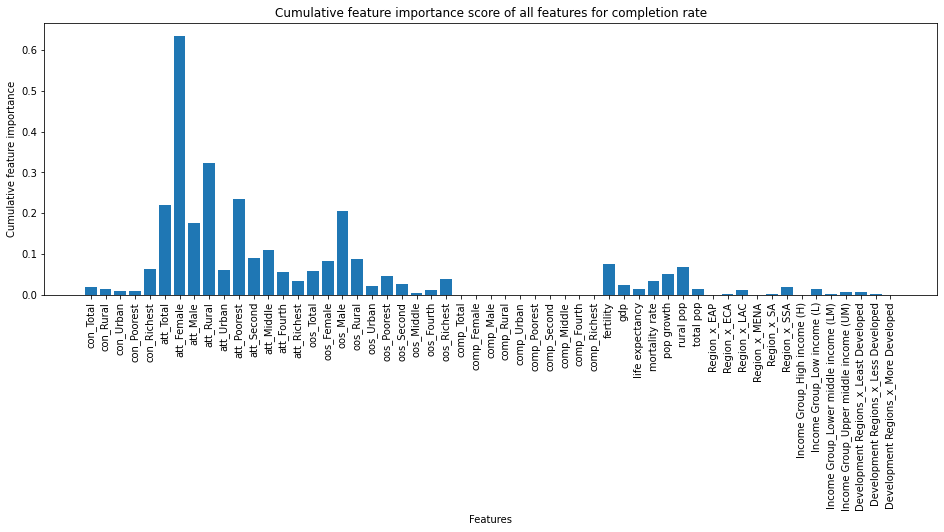

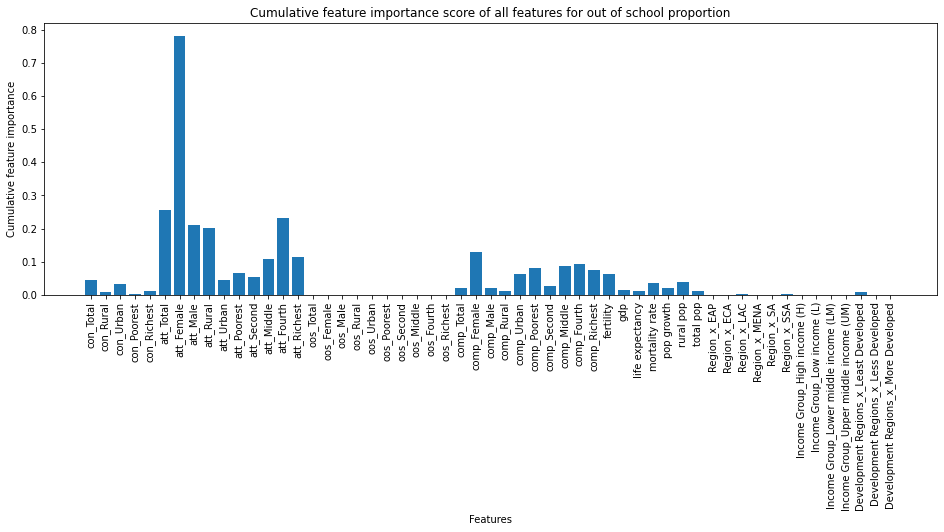

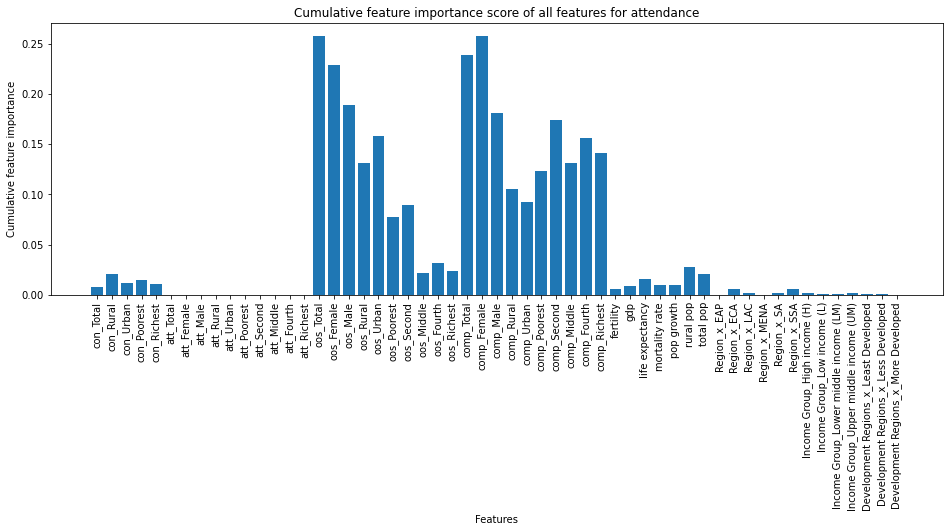

In [20]:
# plot feature importances
for response in top_features.keys():
    fig, ax = plt.subplots(figsize=(16, 5))
    plt_x = np.arange(0, len(top_features[response].values()))
    ax.bar(plt_x, top_features[response].values())
    ax.set_xlabel("Features")
    ax.set_ylabel("Cumulative feature importance")
    plt.xticks(plt_x, top_features[response].keys(), rotation='vertical')
    ax.set_title("Cumulative feature importance score of all features for " + response)

    # let 3 be the minimum times a feature is declared
    top_features[response] = list(sorted(top_features[response].items(), key=lambda item: item[1], reverse=True))
    top_features[response] = [x[0] for x in top_features[response][:number_of_top_features]]

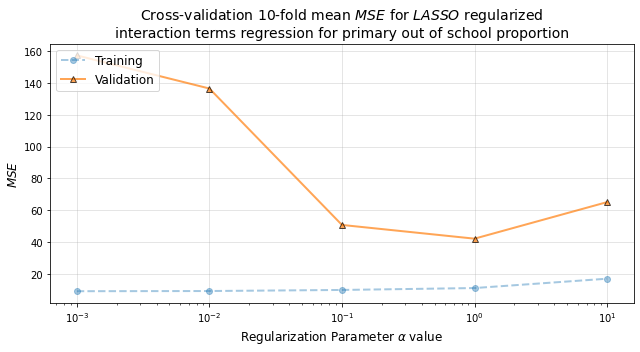

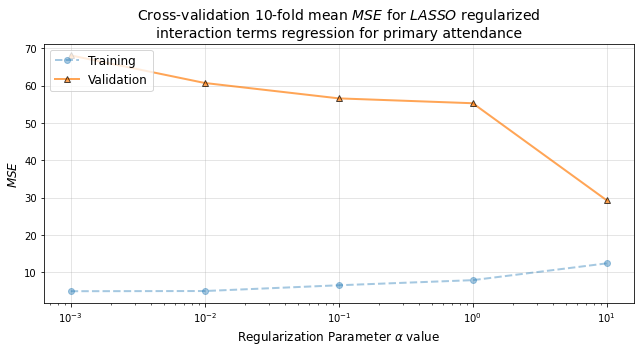

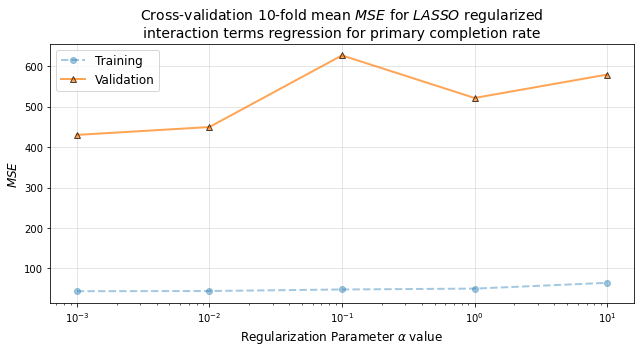

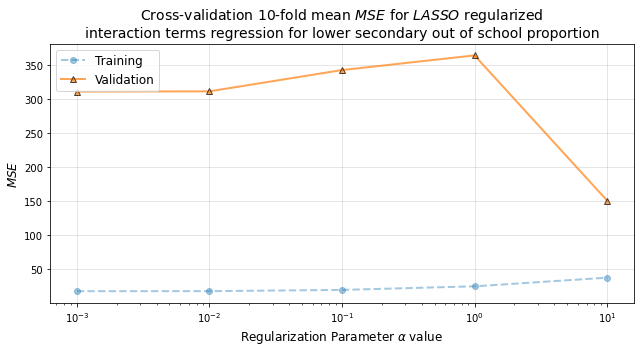

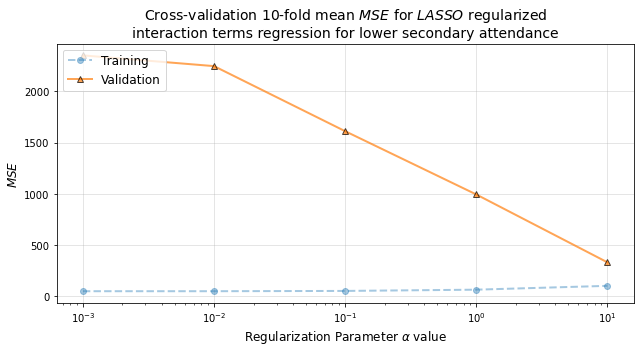

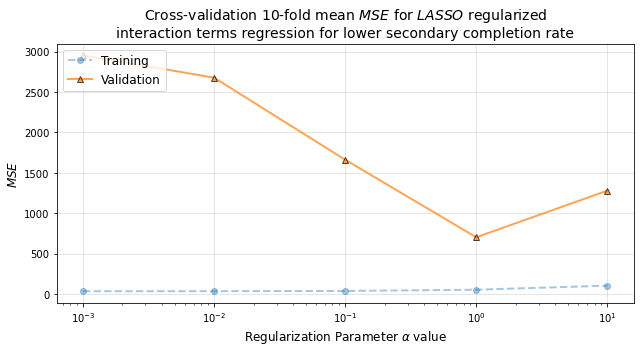

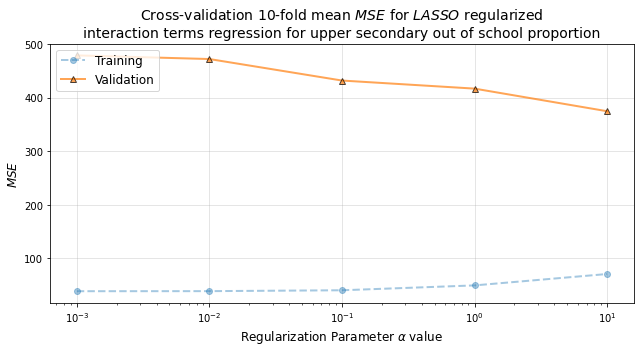

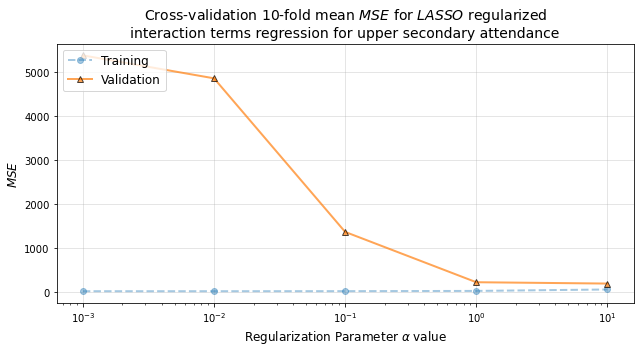

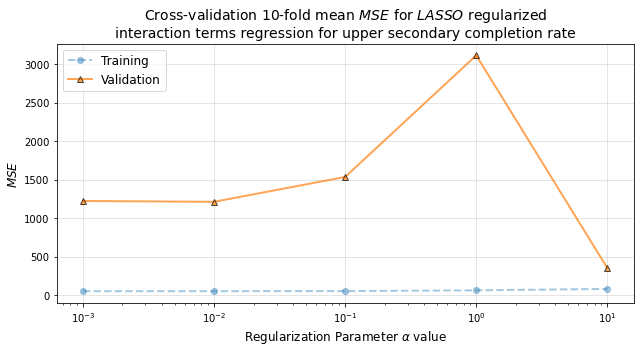

In [21]:
# interaction terms

import warnings
warnings.filterwarnings('ignore')

top_preds_comp = top_features['completion rate']
top_preds_att = top_features['attendance']
top_preds_oos = top_features['out of school proportion']

max_iter = 100000

mse_dict = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
            'lsec oos': [], 'lsec att': [], 'lsec comp': [],
            'usec oos': [], 'usec att': [], 'usec comp': []}

train_score = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
               'lsec oos': [], 'lsec att': [], 'lsec comp': [],
               'usec oos': [], 'usec att': [], 'usec comp': []}

validation_score = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
                    'lsec oos': [], 'lsec att': [], 'lsec comp': [],
                    'usec oos': [], 'usec att': [], 'usec comp': []}

validation_std = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
                  'lsec oos': [], 'lsec att': [], 'lsec comp': [],
                  'usec oos': [], 'usec att': [], 'usec comp': []}

poly_names_dict = {'pri oos': [pri_train_encoded, top_preds_oos, 'oos_Total', pri_test_encoded, 'primary out of school proportion'], 
                   'pri att' : [pri_train_encoded, top_preds_att, 'att_Total', pri_test_encoded, 'primary attendance'], 
                   'pri comp': [pri_train_encoded, top_preds_comp, 'comp_Total', pri_test_encoded, 'primary completion rate'], 
                   'lsec oos': [lsec_train_encoded, top_preds_oos, 'oos_Total', lsec_test_encoded, 'lower secondary out of school proportion'], 
                   'lsec att': [lsec_train_encoded, top_preds_att, 'att_Total', lsec_test_encoded, 'lower secondary attendance'], 
                   'lsec comp': [lsec_train_encoded, top_preds_comp, 'comp_Total', lsec_test_encoded, 'lower secondary completion rate'],
                   'usec oos': [usec_train_encoded, top_preds_oos, 'oos_Total', usec_test_encoded, 'upper secondary out of school proportion'], 
                   'usec att': [usec_train_encoded, top_preds_att, 'att_Total', usec_test_encoded, 'upper secondary attendance'], 
                   'usec comp': [usec_train_encoded, top_preds_comp, 'comp_Total', usec_test_encoded, 'upper secondary completion rate']}

best_alpha_dict = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
                   'lsec oos': [], 'lsec att': [], 'lsec comp': [],
                   'usec oos': [], 'usec att': [], 'usec comp': []}
alpha_list = [1e-3, 1e-2, 1e-1, 1, 1e1]
include_bias = False
fit_intercept = True
interaction_only = True

for name in poly_names_dict.keys():
    train = poly_names_dict[name][0].copy()
    preds = poly_names_dict[name][1]
    response = poly_names_dict[name][2]
    title = poly_names_dict[name][4]

    X_poly_train = train[preds]
    y_train = train[[response]].values

    Poly = PolynomialFeatures(
        interaction_only=interaction_only, include_bias=include_bias
    ).fit(X_poly_train)

    all_colnames = Poly.get_feature_names(preds)

    X_poly_train[all_colnames] = Poly.transform(X_poly_train)
    for alpha in alpha_list: 
        lasso = Lasso(fit_intercept = fit_intercept, alpha = alpha, max_iter = max_iter)
        mse_score = cross_validate(
            lasso, X_poly_train, y_train, cv = 10, 
        scoring = "neg_mean_squared_error", return_train_score = True)
        
        train_score[name].append(np.mean(-mse_score["train_score"]))
        validation_score[name].append(np.mean(-mse_score["test_score"]))
        validation_std[name].append(np.std(mse_score["test_score"]))
    
    x_label = "Regularization Parameter $\\alpha$ value"
    title = (
        "Cross-validation 10-fold mean $MSE$ for $LASSO$ regularized\n"
        "interaction terms regression for " +  title)
    
    mse_plot(
    var_list = alpha_list, 
    train_score = train_score[name],
    val_score = validation_score[name], 
    title = title, 
    x_label = x_label, 
    loc = 2, 
    log_xscale=True,
    )
    
    best_validation_mse = min(validation_score[name])
    best_mse_idx = validation_score[name].index(best_validation_mse)
    best_alpha_dict[name].append(alpha_list[best_mse_idx])
    best_alpha_dict[name].append(best_validation_mse)

In [22]:
# print out results for best alpha
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso

results_lasso_interactions_dict = {}

poly_names_dict = {'pri oos': [pri_train_encoded, top_preds_oos, 'oos_Total', pri_test_encoded, 'primary out of school proportion'], 
                   'pri att' : [pri_train_encoded, top_preds_att, 'att_Total', pri_test_encoded, 'primary attendance'], 
                   'pri comp': [pri_train_encoded, top_preds_comp, 'comp_Total', pri_test_encoded, 'primary completion rate'], 
                   'lsec oos': [lsec_train_encoded, top_preds_oos, 'oos_Total', lsec_test_encoded, 'lower secondary out of school proportion'], 
                   'lsec att': [lsec_train_encoded, top_preds_att, 'att_Total', lsec_test_encoded, 'lower secondary attendance'], 
                   'lsec comp': [lsec_train_encoded, top_preds_comp, 'comp_Total', lsec_test_encoded, 'lower secondary completion rate'],
                   'usec oos': [usec_train_encoded, top_preds_oos, 'oos_Total', usec_test_encoded, 'upper secondary out of school proportion'], 
                   'usec att': [usec_train_encoded, top_preds_att, 'att_Total', usec_test_encoded, 'upper secondary attendance'], 
                   'usec comp': [usec_train_encoded, top_preds_comp, 'comp_Total', usec_test_encoded, 'upper secondary completion rate']}

for name in poly_names_dict.keys():
    train = poly_names_dict[name][0].copy()
    test = poly_names_dict[name][3].copy()
    title = poly_names_dict[name][4]
    best_alpha = best_alpha_dict[name][0]
    preds = poly_names_dict[name][1]
    response = poly_names_dict[name][2]

    X_poly_train = train[preds]
    y_train = train[[response]].values
    
    X_poly_test = test[preds]
    y_test = test[[response]].values

    Poly = PolynomialFeatures(
        interaction_only=interaction_only, include_bias=include_bias
    ).fit(X_poly_train)

    all_colnames = Poly.get_feature_names(preds)

    X_poly_train[all_colnames] = Poly.transform(X_poly_train)
    X_poly_test[all_colnames] = Poly.transform(X_poly_test)
    
    lasso = Lasso(fit_intercept = fit_intercept, alpha = best_alpha, max_iter = max_iter);
    
    lasso.fit(X_poly_train, y_train);
    
    y_train_pred = lasso.predict(X_poly_train)
    y_test_pred = lasso.predict(X_poly_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    results_lasso_interactions_dict['mse train ' + title] = mse_train
    results_lasso_interactions_dict['mse test ' + title] = mse_test

print("The results for interaction terms with LASSO:")
results_lasso_interactions_dict

Lasso(alpha=1, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=0.001, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=1, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

The results for interaction terms with LASSO:


{'mse train primary out of school proportion': 11.453812654755945,
 'mse test primary out of school proportion': 25.250261879226755,
 'mse train primary attendance': 13.125429119831633,
 'mse test primary attendance': 24.502039610512373,
 'mse train primary completion rate': 47.01891197939199,
 'mse test primary completion rate': 409.6958081351536,
 'mse train lower secondary out of school proportion': 39.538447245601574,
 'mse test lower secondary out of school proportion': 116.40837348685847,
 'mse train lower secondary attendance': 110.93682305745698,
 'mse test lower secondary attendance': 208.15006092045041,
 'mse train lower secondary completion rate': 58.867866444387715,
 'mse test lower secondary completion rate': 297.07600598316236,
 'mse train upper secondary out of school proportion': 75.35956690896704,
 'mse test upper secondary out of school proportion': 408.09568890336055,
 'mse train upper secondary attendance': 64.60212060285896,
 'mse test upper secondary attendance': 

In [23]:
# boosting, using a gradient boosting regressor
results_boosting_pred_dict = {}
boosting_predictions = []

for name in data_dict:
    data_train, data_test = data_dict[name]
    for name_response in response_dict:
        response = response_dict[name_response]
        # get the specific list of predictors depending on response
        features_used = all_preds[name_response]
        X_train, y_train = data_train[features_used], data_train[response]
        X_test, y_test = data_test[features_used], data_test[response]
        model = GradientBoostingRegressor(random_state=0, n_estimators=500)
        fit = model.fit(X_train, y_train);
        
        y_pred = model.predict(X_test)
        boosting_predictions.append((X_test['con_Total'], y_pred))
        results_boosting_pred_dict[name + name_response + ' train MSE'] = mean_squared_error(y_train, 
            model.predict(X_train))
        results_boosting_pred_dict[name + name_response + ' test MSE'] = mean_squared_error(y_test, y_pred)

print("The results for boosting:") 
results_boosting_pred_dict

The results for boosting:


{'primary out of school proportion train MSE': 3.18787697037998e-10,
 'primary out of school proportion test MSE': 16.245272456362844,
 'primary completion rate train MSE': 5.043908915680872e-09,
 'primary completion rate test MSE': 217.8665872296071,
 'primary attendance train MSE': 1.8557350122232747e-09,
 'primary attendance test MSE': 32.787807814916526,
 'lower secondary out of school proportion train MSE': 8.247238257081584e-10,
 'lower secondary out of school proportion test MSE': 148.85049077178425,
 'lower secondary completion rate train MSE': 1.6992621197261928e-09,
 'lower secondary completion rate test MSE': 150.72699847453416,
 'lower secondary attendance train MSE': 5.357265953390475e-09,
 'lower secondary attendance test MSE': 291.3091868258698,
 'upper secondary out of school proportion train MSE': 1.2076823655307294e-09,
 'upper secondary out of school proportion test MSE': 244.67348898569105,
 'upper secondary completion rate train MSE': 1.3282777293769451e-09,
 'uppe

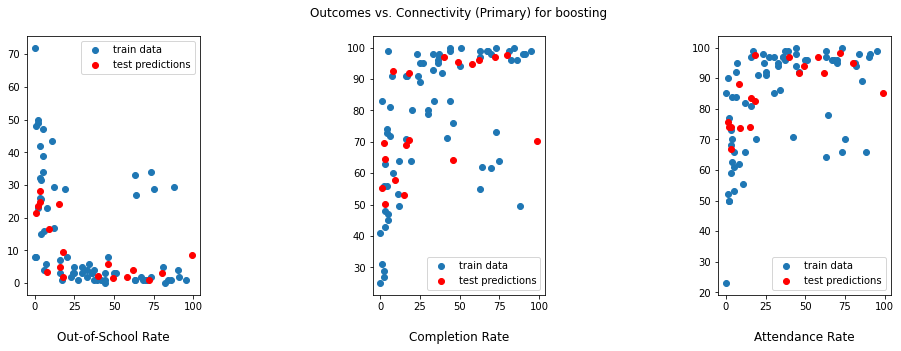

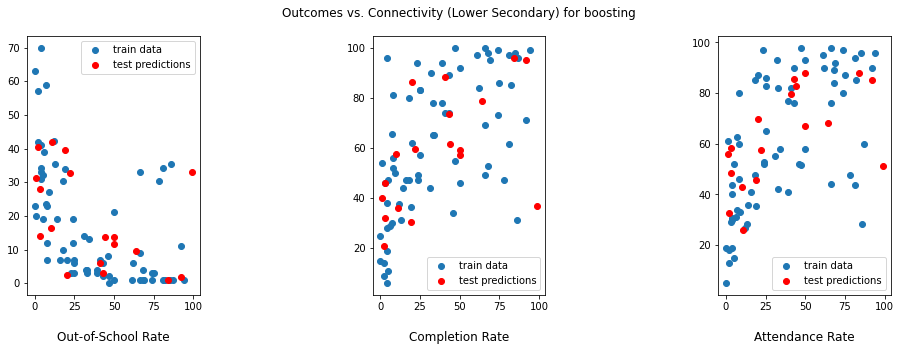

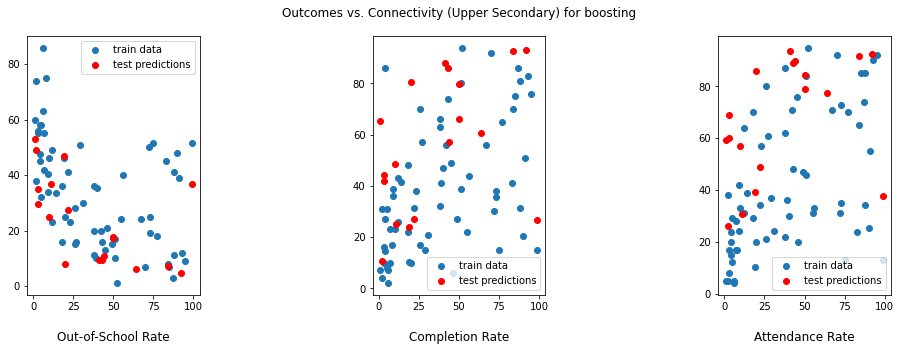

In [24]:
plot_predictions("boosting", boosting_predictions)

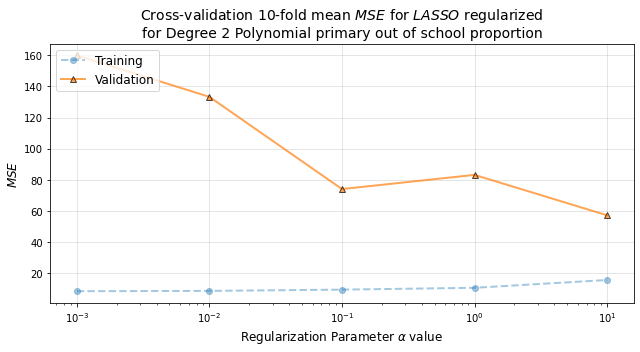

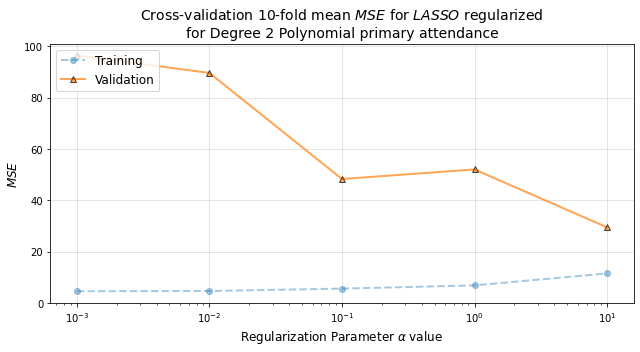

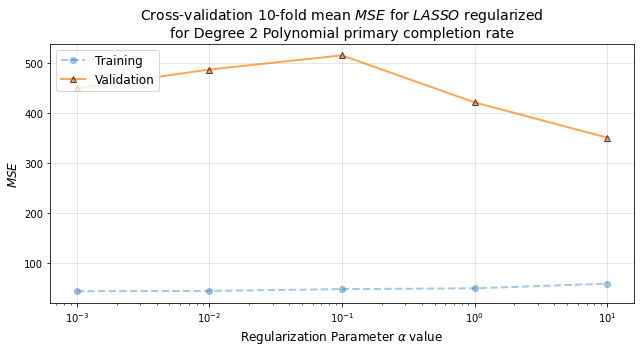

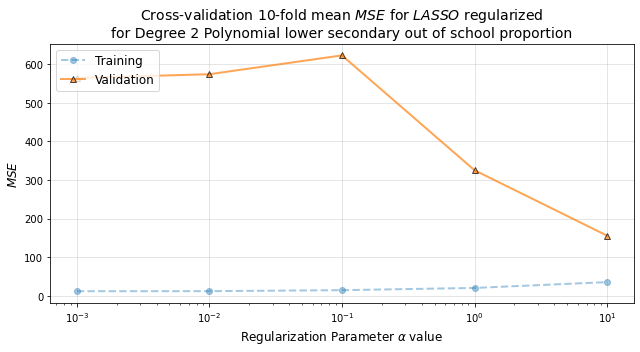

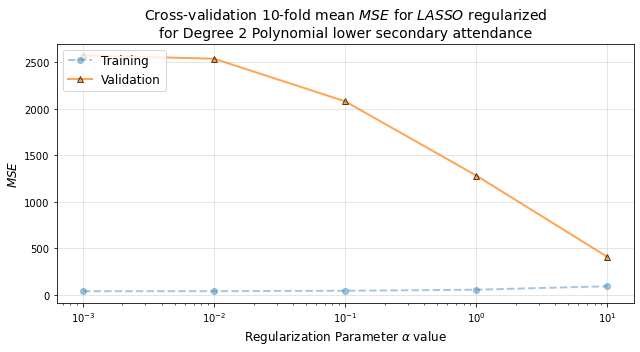

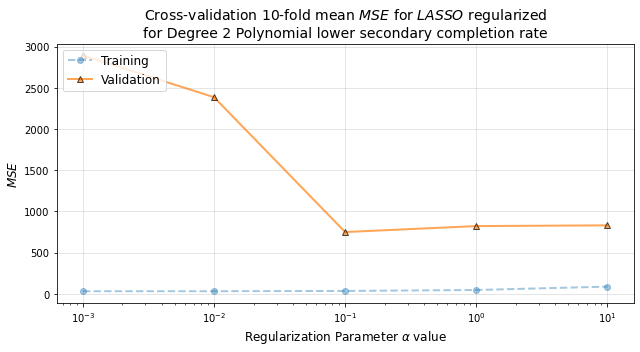

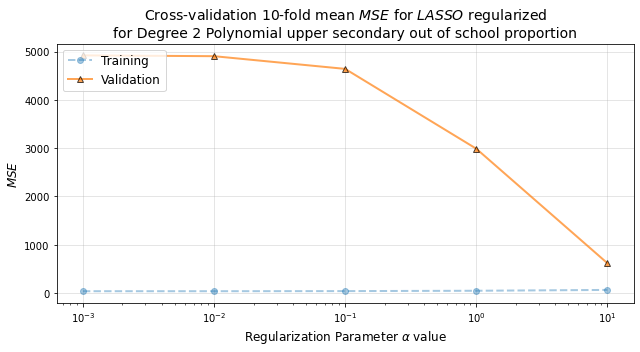

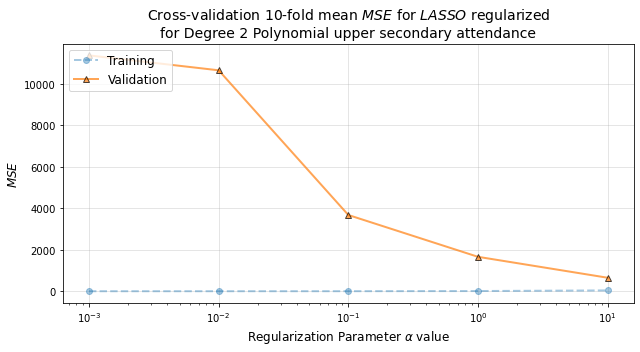

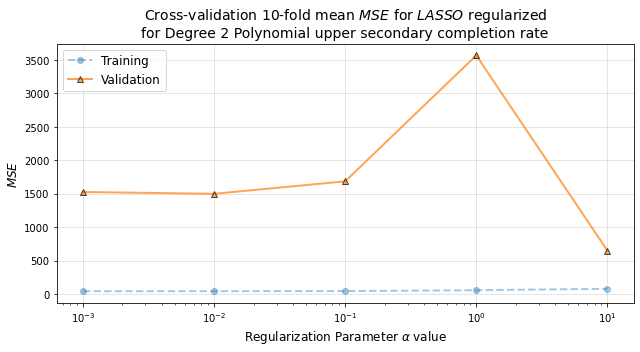

In [25]:
# whole polynomial

import warnings
warnings.filterwarnings('ignore')

top_preds_comp = top_features['completion rate']
top_preds_att = top_features['attendance']
top_preds_oos = top_features['out of school proportion']

max_iter = 100000

mse_dict = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
            'lsec oos': [], 'lsec att': [], 'lsec comp': [],
            'usec oos': [], 'usec att': [], 'usec comp': []}

train_score = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
               'lsec oos': [], 'lsec att': [], 'lsec comp': [],
               'usec oos': [], 'usec att': [], 'usec comp': []}

validation_score = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
                    'lsec oos': [], 'lsec att': [], 'lsec comp': [],
                    'usec oos': [], 'usec att': [], 'usec comp': []}

validation_std = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
                  'lsec oos': [], 'lsec att': [], 'lsec comp': [],
                  'usec oos': [], 'usec att': [], 'usec comp': []}

poly_names_dict = {'pri oos': [pri_train_encoded, top_preds_oos, 'oos_Total', pri_test_encoded, 'primary out of school proportion'], 
                   'pri att' : [pri_train_encoded, top_preds_att, 'att_Total', pri_test_encoded, 'primary attendance'], 
                   'pri comp': [pri_train_encoded, top_preds_comp, 'comp_Total', pri_test_encoded, 'primary completion rate'], 
                   'lsec oos': [lsec_train_encoded, top_preds_oos, 'oos_Total', lsec_test_encoded, 'lower secondary out of school proportion'], 
                   'lsec att': [lsec_train_encoded, top_preds_att, 'att_Total', lsec_test_encoded, 'lower secondary attendance'], 
                   'lsec comp': [lsec_train_encoded, top_preds_comp, 'comp_Total', lsec_test_encoded, 'lower secondary completion rate'],
                   'usec oos': [usec_train_encoded, top_preds_oos, 'oos_Total', usec_test_encoded, 'upper secondary out of school proportion'], 
                   'usec att': [usec_train_encoded, top_preds_att, 'att_Total', usec_test_encoded, 'upper secondary attendance'], 
                   'usec comp': [usec_train_encoded, top_preds_comp, 'comp_Total', usec_test_encoded, 'upper secondary completion rate']}

alpha_dict_poly = {'pri oos': [], 'pri att' : [], 'pri comp': [], 
                   'lsec oos': [], 'lsec att': [], 'lsec comp': [],
                   'usec oos': [], 'usec att': [], 'usec comp': []}
alpha_list = [1e-3, 1e-2, 1e-1, 1, 1e1]
include_bias = False
fit_intercept = True
interaction_only = False

for name in poly_names_dict.keys():
    train = poly_names_dict[name][0].copy()
    preds = poly_names_dict[name][1]
    response = poly_names_dict[name][2]
    title = poly_names_dict[name][4]

    X_poly_train = train[preds]
    y_train = train[[response]].values

    Poly = PolynomialFeatures(
        interaction_only=interaction_only, include_bias=include_bias
    ).fit(X_poly_train)

    all_colnames = Poly.get_feature_names(preds)

    X_poly_train[all_colnames] = Poly.transform(X_poly_train)
    for alpha in alpha_list: 
        lasso = Lasso(fit_intercept = fit_intercept, alpha = alpha, max_iter = max_iter)
        mse_score = cross_validate(
            lasso, X_poly_train, y_train, cv = 10, 
        scoring = "neg_mean_squared_error", return_train_score = True)
        
        train_score[name].append(np.mean(-mse_score["train_score"]))
        validation_score[name].append(np.mean(-mse_score["test_score"]))
        validation_std[name].append(np.std(mse_score["test_score"]))
    
    x_label = "Regularization Parameter $\\alpha$ value"
    title = (
        "Cross-validation 10-fold mean $MSE$ for $LASSO$ regularized\n"
        "for Degree 2 Polynomial " +  title)
    
    mse_plot(
    var_list = alpha_list, 
    train_score = train_score[name],
    val_score = validation_score[name], 
    title = title, 
    x_label = x_label, 
    loc = 2, 
    log_xscale=True,
    )
    
    best_validation_mse = min(validation_score[name])
    best_mse_idx = validation_score[name].index(best_validation_mse)
    alpha_dict_poly[name].append(alpha_list[best_mse_idx])
    alpha_dict_poly[name].append(best_validation_mse)

In [26]:
# print out results for best alpha
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso

results_lasso_polynomial_dict = {}

poly_names_dict = {'pri oos': [pri_train_encoded, top_preds_oos, 'oos_Total', pri_test_encoded, 'primary out of school proportion'], 
                   'pri att' : [pri_train_encoded, top_preds_att, 'att_Total', pri_test_encoded, 'primary attendance'], 
                   'pri comp': [pri_train_encoded, top_preds_comp, 'comp_Total', pri_test_encoded, 'primary completion rate'], 
                   'lsec oos': [lsec_train_encoded, top_preds_oos, 'oos_Total', lsec_test_encoded, 'lower secondary out of school proportion'], 
                   'lsec att': [lsec_train_encoded, top_preds_att, 'att_Total', lsec_test_encoded, 'lower secondary attendance'], 
                   'lsec comp': [lsec_train_encoded, top_preds_comp, 'comp_Total', lsec_test_encoded, 'lower secondary completion rate'],
                   'usec oos': [usec_train_encoded, top_preds_oos, 'oos_Total', usec_test_encoded, 'upper secondary out of school proportion'], 
                   'usec att': [usec_train_encoded, top_preds_att, 'att_Total', usec_test_encoded, 'upper secondary attendance'], 
                   'usec comp': [usec_train_encoded, top_preds_comp, 'comp_Total', usec_test_encoded, 'upper secondary completion rate']}

for name in poly_names_dict.keys():
    train = poly_names_dict[name][0].copy()
    test = poly_names_dict[name][3].copy()
    title = poly_names_dict[name][4]
    best_alpha = best_alpha_dict[name][0]
    preds = poly_names_dict[name][1]
    response = poly_names_dict[name][2]

    X_poly_train = train[preds]
    y_train = train[[response]].values
    
    X_poly_test = test[preds]
    y_test = test[[response]].values

    Poly = PolynomialFeatures(
        interaction_only=interaction_only, include_bias=include_bias
    ).fit(X_poly_train)

    all_colnames = Poly.get_feature_names(preds)

    X_poly_train[all_colnames] = Poly.transform(X_poly_train)
    X_poly_test[all_colnames] = Poly.transform(X_poly_test)
    
    lasso = Lasso(fit_intercept = fit_intercept, alpha = best_alpha, max_iter = max_iter);
    
    lasso.fit(X_poly_train, y_train);
    
    y_train_pred = lasso.predict(X_poly_train)
    y_test_pred = lasso.predict(X_poly_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    results_lasso_polynomial_dict['mse train ' + title] = mse_train
    results_lasso_polynomial_dict['mse test ' + title] = mse_test
    
print("The results for polynomial regression with LASSO:")
results_lasso_polynomial_dict

Lasso(alpha=1, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=0.001, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=1, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

Lasso(alpha=10.0, max_iter=100000)

The results for polynomial regression with LASSO:


{'mse train primary out of school proportion': 11.175190849708786,
 'mse test primary out of school proportion': 24.30980023224731,
 'mse train primary attendance': 12.216391692132362,
 'mse test primary attendance': 27.080101201704416,
 'mse train primary completion rate': 46.92559755189665,
 'mse test primary completion rate': 512.4810990481443,
 'mse train lower secondary out of school proportion': 37.40277549326447,
 'mse test lower secondary out of school proportion': 101.32429260661135,
 'mse train lower secondary attendance': 104.26437439377574,
 'mse test lower secondary attendance': 215.42249160861076,
 'mse train lower secondary completion rate': 51.0135647923573,
 'mse test lower secondary completion rate': 213.99243891742313,
 'mse train upper secondary out of school proportion': 67.97792251465697,
 'mse test upper secondary out of school proportion': 568.2430931754852,
 'mse train upper secondary attendance': 57.977656421650245,
 'mse test upper secondary attendance': 193.

In [27]:
def bootstrap(df):
    selectionIndex = np.random.randint(len(df), size = len(df))
    new_df = df.iloc[selectionIndex]
    return new_df

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

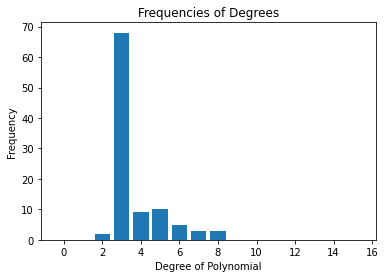

In [28]:
# PRIMARY OOS SINGLE PREDICTOR POLYNOMIAL REGRESSION
single_pred_poly_train_MSE = {}
single_pred_poly_test_MSE = {}

number_of_bootstraps = 100
maxdeg = 16
best_degree_list = []

for i in range(number_of_bootstraps):
    pri_train_encoded_boot = bootstrap(pri_train_encoded)
    x_train_boot = pri_train_encoded_boot[["con_Total"]].values
    y_train_boot = pri_train_encoded_boot["oos_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [29]:
print(best_degree_dict)

{0: 0, 1: 0, 2: 2, 3: 68, 4: 9, 5: 10, 6: 5, 7: 3, 8: 3, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [30]:
overall_best_degree = 3

x_train = pri_train_encoded[['con_Total']].values
y_train = pri_train_encoded['oos_Total'].values
x_test = pri_test_encoded[['con_Total']]
y_test = pri_test_encoded['oos_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['pri oos'] = MSE_train
single_pred_poly_test_MSE['pri oos'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 144.0406.
The test MSE is 85.6473.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Out-of-School Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 3')

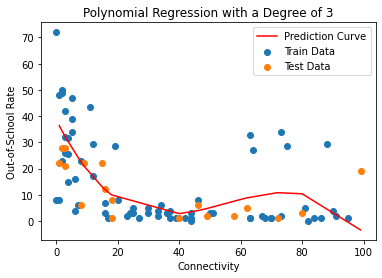

In [31]:
# sort then plot
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Out-of-School Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

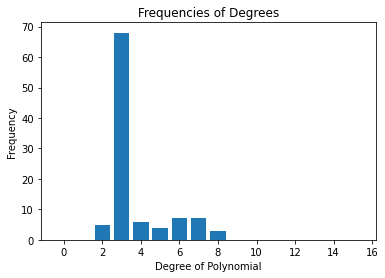

In [32]:
# PRIMARY ATT SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    pri_train_encoded_boot = bootstrap(pri_train_encoded)
    x_train_boot = pri_train_encoded_boot[["con_Total"]].values
    y_train_boot = pri_train_encoded_boot["att_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [33]:
print(best_degree_dict)

{0: 0, 1: 0, 2: 5, 3: 68, 4: 6, 5: 4, 6: 7, 7: 7, 8: 3, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [34]:
overall_best_degree = 3

x_train = pri_train_encoded[['con_Total']].values
y_train = pri_train_encoded['att_Total'].values
x_test = pri_test_encoded[['con_Total']]
y_test = pri_test_encoded['att_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['pri att'] = MSE_train
single_pred_poly_test_MSE['pri att'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 154.7201.
The test MSE is 125.5325.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Attendance Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 3')

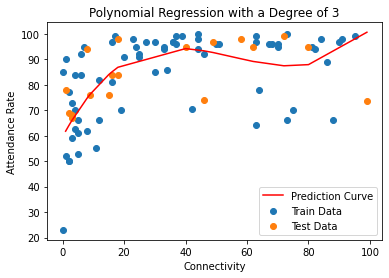

In [35]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Attendance Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

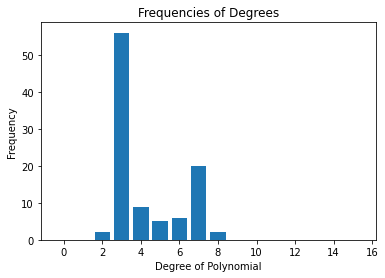

In [36]:
# PRIMARY COMP SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    pri_train_encoded_boot = bootstrap(pri_train_encoded)
    x_train_boot = pri_train_encoded_boot[["con_Total"]].values
    y_train_boot = pri_train_encoded_boot["comp_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [37]:
print(best_degree_dict)

{0: 0, 1: 0, 2: 2, 3: 56, 4: 9, 5: 5, 6: 6, 7: 20, 8: 2, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [38]:
overall_best_degree = 3

x_train = pri_train_encoded[['con_Total']].values
y_train = pri_train_encoded['comp_Total'].values
x_test = pri_test_encoded[['con_Total']]
y_test = pri_test_encoded['comp_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['pri comp'] = MSE_train
single_pred_poly_test_MSE['pri comp'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 235.5676.
The test MSE is 402.0647.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Completion Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 3')

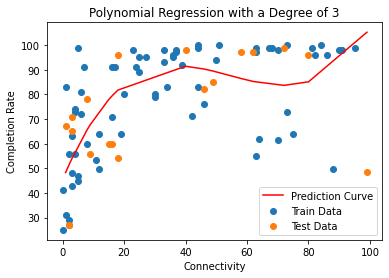

In [39]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Completion Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

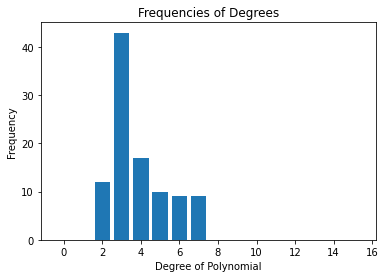

In [40]:
# LOWER OOS SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    lsec_train_encoded_boot = bootstrap(lsec_train_encoded)
    x_train_boot = lsec_train_encoded_boot[["con_Total"]].values
    y_train_boot = lsec_train_encoded_boot["oos_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [41]:
print(best_degree_dict)

{0: 0, 1: 0, 2: 12, 3: 43, 4: 17, 5: 10, 6: 9, 7: 9, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [42]:
overall_best_degree = 3

x_train = lsec_train_encoded[['con_Total']].values
y_train = lsec_train_encoded['oos_Total'].values
x_test = lsec_test_encoded[['con_Total']]
y_test = lsec_test_encoded['oos_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['lsec oos'] = MSE_train
single_pred_poly_test_MSE['lsec oos'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 141.5874.
The test MSE is 108.8668.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Out-of-School Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 3')

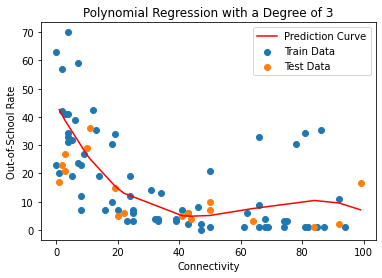

In [43]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Out-of-School Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

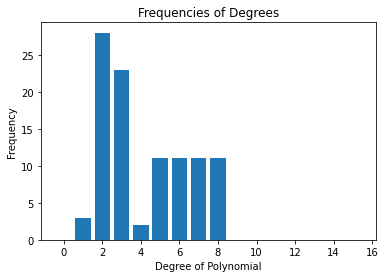

In [44]:
# LOWER ATT SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    lsec_train_encoded_boot = bootstrap(lsec_train_encoded)
    x_train_boot = lsec_train_encoded_boot[["con_Total"]].values
    y_train_boot = lsec_train_encoded_boot["att_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [45]:
print(best_degree_dict)

{0: 0, 1: 3, 2: 28, 3: 23, 4: 2, 5: 11, 6: 11, 7: 11, 8: 11, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [46]:
overall_best_degree = 2

x_train = lsec_train_encoded[['con_Total']].values
y_train = lsec_train_encoded['att_Total'].values
x_test = lsec_test_encoded[['con_Total']]
y_test = lsec_test_encoded['att_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['lsec att'] = MSE_train
single_pred_poly_test_MSE['lsec att'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 378.6004.
The test MSE is 411.4263.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Attendance Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 2')

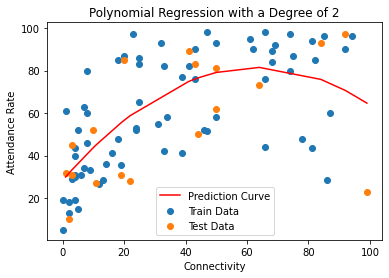

In [47]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Attendance Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

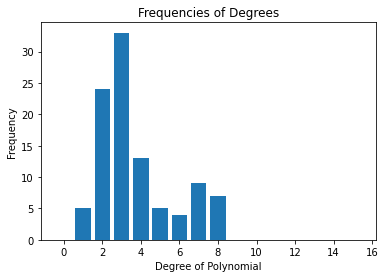

In [48]:
# LOWER COMP SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    lsec_train_encoded_boot = bootstrap(lsec_train_encoded)
    x_train_boot = lsec_train_encoded_boot[["con_Total"]].values
    y_train_boot = lsec_train_encoded_boot["comp_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [49]:
print(best_degree_dict)

{0: 0, 1: 5, 2: 24, 3: 33, 4: 13, 5: 5, 6: 4, 7: 9, 8: 7, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [50]:
overall_best_degree = 2

x_train = lsec_train_encoded[['con_Total']].values
y_train = lsec_train_encoded['comp_Total'].values
x_test = lsec_test_encoded[['con_Total']]
y_test = lsec_test_encoded['comp_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['lsec comp'] = MSE_train
single_pred_poly_test_MSE['lsec comp'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 418.9996.
The test MSE is 408.7287.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Completion Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 2')

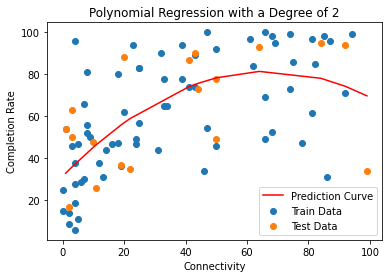

In [51]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Completion Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

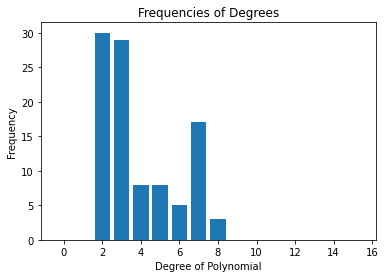

In [52]:
# UPPER OOS SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    usec_train_encoded_boot = bootstrap(usec_train_encoded)
    x_train_boot = usec_train_encoded_boot[["con_Total"]].values
    y_train_boot = usec_train_encoded_boot["oos_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [53]:
print(best_degree_dict)

{0: 0, 1: 0, 2: 30, 3: 29, 4: 8, 5: 8, 6: 5, 7: 17, 8: 3, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [54]:
overall_best_degree = 2

x_train = usec_train_encoded[['con_Total']].values
y_train = usec_train_encoded['oos_Total'].values
x_test = usec_test_encoded[['con_Total']]
y_test = usec_test_encoded['oos_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['usec oos'] = MSE_train
single_pred_poly_test_MSE['usec oos'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 205.5467.
The test MSE is 257.7447.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Attendance Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 2')

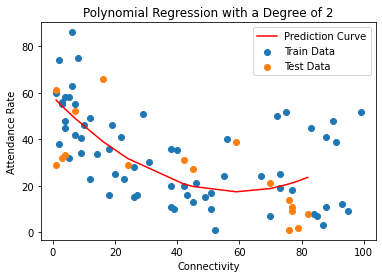

In [55]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Attendance Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

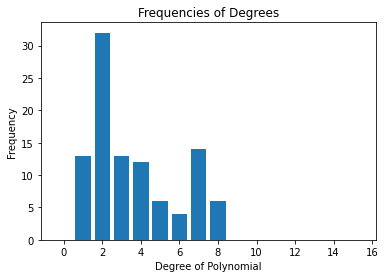

In [56]:
# UPPER ATT SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    usec_train_encoded_boot = bootstrap(usec_train_encoded)
    x_train_boot = usec_train_encoded_boot[["con_Total"]].values
    y_train_boot = usec_train_encoded_boot["att_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [57]:
print(best_degree_dict)

{0: 0, 1: 13, 2: 32, 3: 13, 4: 12, 5: 6, 6: 4, 7: 14, 8: 6, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [58]:
overall_best_degree = 2

x_train = usec_train_encoded[['con_Total']].values
y_train = usec_train_encoded['att_Total'].values
x_test = usec_test_encoded[['con_Total']]
y_test = usec_test_encoded['att_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['usec att'] = MSE_train
single_pred_poly_test_MSE['usec att'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 479.4375.
The test MSE is 236.2066.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Attendance Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 2')

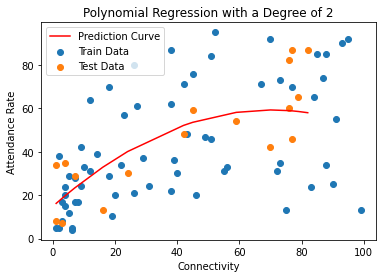

In [59]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Attendance Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

<BarContainer object of 16 artists>

Text(0.5, 0, 'Degree of Polynomial')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequencies of Degrees')

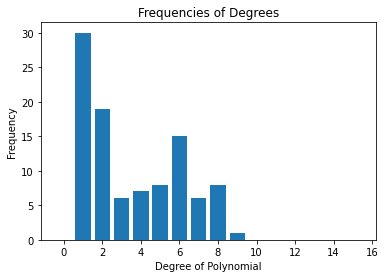

In [60]:
# UPPER COMP SINGLE PREDICTOR POLYNOMIAL REGRESSION
best_degree_list = []

for i in range(number_of_bootstraps):
    usec_train_encoded_boot = bootstrap(usec_train_encoded)
    x_train_boot = usec_train_encoded_boot[["con_Total"]].values
    y_train_boot = usec_train_encoded_boot["comp_Total"].values
    validation_error = []
    for d in range(maxdeg):
        x_poly_train_boot = PolynomialFeatures(degree=d).fit_transform(x_train_boot)
        lreg = LinearRegression(fit_intercept=False)
        mse_score = cross_validate(lreg, x_poly_train_boot, y_train_boot, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
        validation_error.append(-np.mean(mse_score['test_score']))
    mse_validation = min(validation_error)
    best_degree_list.append(validation_error.index(mse_validation))

best_degree_dict = {}
for i in range(maxdeg):
    best_degree_dict[i] = best_degree_list.count(i) 

plt.bar(np.arange(0, maxdeg), best_degree_dict.values())
plt.xlabel("Degree of Polynomial")
plt.ylabel("Frequency")
plt.title("Frequencies of Degrees")

In [61]:
print(best_degree_dict)

{0: 0, 1: 30, 2: 19, 3: 6, 4: 7, 5: 8, 6: 15, 7: 6, 8: 8, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


In [62]:
overall_best_degree = 1

x_train = usec_train_encoded[['con_Total']].values
y_train = usec_train_encoded['comp_Total'].values
x_test = usec_test_encoded[['con_Total']]
y_test = usec_test_encoded['comp_Total']

x_poly_train = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=overall_best_degree).fit_transform(x_test)

polymodel = LinearRegression(fit_intercept=False)
polymodel.fit(x_poly_train, y_train)

y_train_pred = polymodel.predict(x_poly_train)
y_test_pred = polymodel.predict(x_poly_test)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

single_pred_poly_train_MSE['usec comp'] = MSE_train
single_pred_poly_test_MSE['usec comp'] = MSE_test

print(f"The train MSE is {MSE_train:.4f}.")
print(f"The test MSE is {MSE_test:.4f}.")

LinearRegression(fit_intercept=False)

The train MSE is 484.8548.
The test MSE is 477.4071.


Text(0.5, 0, 'Connectivity')

Text(0, 0.5, 'Completion Rate')

Text(0.5, 1.0, 'Polynomial Regression with a Degree of 1')

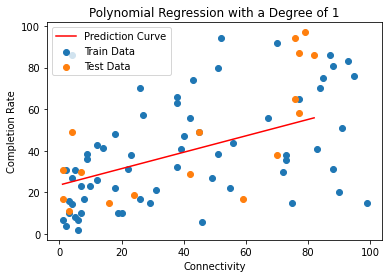

In [63]:
y_poly_pred = pd.DataFrame(y_test_pred, index=x_test.index)
x_poly = x_test.sort_values(x_test.columns[0])
idx = x_poly.index
y_poly_pred = y_poly_pred.loc[idx]

plt.scatter(x_train, y_train, label="Train Data")
plt.scatter(x_test, y_test, label="Test Data")
plt.plot(x_poly.values, y_poly_pred.values, label="Prediction Curve", color="red")
plt.xlabel("Connectivity")
plt.ylabel("Completion Rate")
plt.title(f"Polynomial Regression with a Degree of {overall_best_degree}")
plt.legend()

In [64]:
# MULTIPLE REGRESSION WITH ALL PREDICTORS
data_dict = {'primary ': [pri_train_encoded, pri_test_encoded], 
             'lower secondary ': [lsec_train_encoded, lsec_test_encoded], 
             'upper secondary ': [usec_train_encoded, lsec_test_encoded]}

response_dict = {'out of school proportion': 'oos_Total', 'completion rate': 'comp_Total', 'attendance': 'att_Total'}

preds_dict = {'out of school proportion': preds_oos, 'completion rate': preds_comp, 'attendance': preds_att}

results_multiple_pred_dict = {}

for name in data_dict:
    data_train = data_dict[name][0]
    data_test = data_dict[name][1]
    for name_response in response_dict:
        response = response_dict[name_response]
        preds = preds_dict[name_response]
        X_train, y_train = data_train[preds], data_train[[response]]
        X_test, y_test = data_test[preds], data_test[[response]]
        model = LinearRegression();
        fit = model.fit(X_train, y_train);
        results_multiple_pred_dict[name + name_response + ' coefficients'] = model.coef_[0].tolist()
        results_multiple_pred_dict[name + name_response + ' intercept'] = model.intercept_[0]
        results_multiple_pred_dict[name + name_response + ' train MSE'] = mean_squared_error(y_train, 
            model.predict(X_train))
        results_multiple_pred_dict[name + name_response + ' test MSE'] = mean_squared_error(y_test, 
            model.predict(X_test))

print("The results for multiple regression with all predictors are") 
results_multiple_pred_dict

The results for multiple regression with all predictors are


{'primary out of school proportion coefficients': [0.012406281906655945,
  -0.012013824872798883,
  0.050349609066331805,
  -0.013324220062088419,
  -0.08940187288861941,
  -0.4687410393881114,
  0.07063588198412891,
  -0.8658703021895434,
  0.23950290615508477,
  0.03932280555913268,
  0.7157327707874516,
  -0.3729116180340669,
  -0.2471852795166618,
  -0.19719203017892584,
  0.144097544987999,
  0.23129737861837732,
  -0.14044133711073506,
  0.3099735387951527,
  -0.06986905965419551,
  -0.2581797319447511,
  -0.10224435735193634,
  0.21295082385986194,
  -0.7811237794604197,
  0.33345822843438017,
  0.5300731320986407,
  1.1476481741286708,
  -1.1449174941446927e-16,
  0.055800587295069586,
  0.015536618207876876,
  -0.11555246130059518,
  0.005982814569917127,
  1.887617512837124e-06,
  0.3298933669295745,
  -0.23524853265433676,
  -0.2537220237774592,
  -0.016257146916361254,
  -0.1422004503864752,
  0.3175347868050573,
  0.19031318552282603,
  0.19761459627465358,
  0.27177671614

In [65]:
# MULTIPLE REGRESSION WITH PREDICTORS FROM RANDOM FOREST
data_dict = {'primary ': [pri_train_encoded, pri_test_encoded], 
             'lower secondary ': [lsec_train_encoded, lsec_test_encoded], 
             'upper secondary ': [usec_train_encoded, lsec_test_encoded]}

response_dict = {'out of school proportion': 'oos_Total', 'completion rate': 'comp_Total', 'attendance': 'att_Total'}

results_multiple_pred_rf_dict = {}

for name in data_dict:
    data_train = data_dict[name][0]
    data_test = data_dict[name][1]
    for name_response in response_dict:
        response = response_dict[name_response]
        preds = top_features[name_response]
        X_train, y_train = data_train[preds], data_train[[response]]
        X_test, y_test = data_test[preds], data_test[[response]]
        model = LinearRegression();
        fit = model.fit(X_train, y_train);
        results_multiple_pred_rf_dict[name + name_response + ' coefficients'] = model.coef_[0].tolist()
        results_multiple_pred_rf_dict[name + name_response + ' intercept'] = model.intercept_[0]
        results_multiple_pred_rf_dict[name + name_response + ' train MSE'] = mean_squared_error(y_train, 
            model.predict(X_train))
        results_multiple_pred_rf_dict[name + name_response + ' test MSE'] = mean_squared_error(y_test, 
            model.predict(X_test))

print("The results for multiple regression with predictors selected by random forest are") 
results_multiple_pred_rf_dict

The results for multiple regression with predictors selected by random forest are


{'primary out of school proportion coefficients': [-0.2880778206242019,
  -0.6906238486131067,
  -0.42781592114211475,
  0.04664819833831582,
  -0.059179423493385425,
  0.08674913916167493,
  0.6155426452402861,
  0.0984849427670568,
  0.08605434303396786,
  -0.1445060534680293],
 'primary out of school proportion intercept': 66.38098512124819,
 'primary out of school proportion train MSE': 16.40026841141664,
 'primary out of school proportion test MSE': 24.083179506171565,
 'primary completion rate coefficients': [3.75171784837922,
  0.0964241172260295,
  0.558433826720141,
  -5.797540379770499,
  0.9488670651610546,
  3.047578197258354,
  0.5395430271264989,
  -1.2597825239478833,
  -1.1928136264181375,
  0.24443718051852995],
 'primary completion rate intercept': 3.218434055817596,
 'primary completion rate train MSE': 92.06429034699254,
 'primary completion rate test MSE': 220.56955644690052,
 'primary attendance coefficients': [-2.004818336795549,
  1.0875362362306316,
  -2.194470

In [66]:
# consolidating all results into a dictionary 
results_train_dict = {'pri oos': [], 'pri att': [], 'pri comp': [], 
                      'lsec oos': [], 'lsec att': [], 'lsec comp': [], 
                      'usec oos': [], 'usec att': [], 'usec comp': []}

results_test_dict = {'pri oos': [], 'pri att': [], 'pri comp': [], 
                     'lsec oos': [], 'lsec att': [], 'lsec comp': [], 
                     'usec oos': [], 'usec att': [], 'usec comp': []}

titles_dict = {'primary out of school proportion': 'pri oos', 'primary completion rate': 'pri comp', 'primary attendance': 'pri att',
               'lower secondary out of school proportion': 'lsec oos', 'lower secondary completion rate': 'lsec comp', 'lower secondary attendance': 'lsec att',
               'upper secondary out of school proportion': 'usec oos', 'upper secondary completion rate': 'usec comp', 'upper secondary attendance': 'usec att'}

def get_key(val, sample_dict):
    for key, value in sample_dict.items():
         if val == value:
             return key
    return "key doesn't exist"

import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

for name in results_train_dict.keys():
    title = get_key(name, titles_dict)
    # for one predictor
    results_train_dict[name].append(truncate(mse_train_one_pred[name], digits = 3))
    results_test_dict[name].append(truncate(mse_test_one_pred[name], digits = 3))
    
    # for two predictors
    results_train_dict[name].append(truncate(mse_train_two_preds[name], digits = 3))
    results_test_dict[name].append(truncate(mse_test_two_preds[name], digits = 3))

    # polynomial one predictor
    results_train_dict[name].append(truncate(single_pred_poly_train_MSE[name], digits = 3)) 
    results_test_dict[name].append(truncate(single_pred_poly_test_MSE[name], digits = 3)) 

    # linear regression all predictors
    results_train_dict[name].append(truncate(results_multiple_pred_dict[title + ' train MSE'], digits = 3))
    results_test_dict[name].append(truncate(results_multiple_pred_dict[title + ' test MSE'], digits = 3))

    # linear regression selected predictors
    results_train_dict[name].append(truncate(results_multiple_pred_rf_dict[title + ' train MSE'], digits = 3))
    results_test_dict[name].append(truncate(results_multiple_pred_rf_dict[title + ' test MSE'], digits = 3))

    # polynomial regression with LASSO
    results_train_dict[name].append(truncate(results_lasso_polynomial_dict['mse train ' + title], digits = 3))
    results_test_dict[name].append(truncate(results_lasso_polynomial_dict['mse test ' + title], digits = 3))

    # interaction terms with LASSO
    results_train_dict[name].append(truncate(results_lasso_interactions_dict['mse train ' + title], digits = 3))
    results_test_dict[name].append(truncate(results_lasso_interactions_dict['mse test ' + title], digits = 3))

    # boosting
    results_train_dict[name].append(results_boosting_pred_dict[title + ' train MSE'])   
    results_test_dict[name].append(truncate(results_boosting_pred_dict[title + ' test MSE'], digits = 3))      

In [67]:
# converting dictionaries into data frames
results_train = pd.DataFrame(results_train_dict, index = ['one pred', 'two preds', 'poly one pred', 'OLS all preds', 'OLS selected preds', 'poly LASSO', 'interaction LASSO', 'boosting'])
results_train

,pri oos,pri att,pri comp,lsec oos,lsec att,lsec comp,usec oos,usec att,usec comp
one pred,2.198000e+02,2.216560e+02,3.467120e+02,2.127180e+02,4.576250e+02,4.758580e+02,2.840870e+02,5.258420e+02,4.848540e+02
two preds,1.642930e+02,1.786930e+02,2.422170e+02,1.525180e+02,3.466420e+02,3.519400e+02,2.238640e+02,4.177250e+02,3.924200e+02
poly one pred,1.440400e+02,1.547200e+02,2.355670e+02,1.415870e+02,3.786000e+02,4.189990e+02,2.055460e+02,4.794370e+02,4.848540e+02
OLS all preds,1.677400e+01,9.096000e+00,4.222800e+01,5.026200e+01,7.449900e+01,8.621800e+01,7.345400e+01,4.952600e+01,7.912100e+01
OLS selected preds,1.640000e+01,1.536900e+01,9.206400e+01,5.429500e+01,1.191320e+02,1.527240e+02,1.002560e+02,8.577100e+01,1.323990e+02
poly LASSO,1.117500e+01,1.221600e+01,4.692500e+01,3.740200e+01,1.042640e+02,5.101300e+01,6.797700e+01,5.797700e+01,8.452800e+01
interaction LASSO,1.145300e+01,1.312500e+01,4.701800e+01,3.953800e+01,1.109360e+02,5.886700e+01,7.535900e+01,6.460200e+01,8.517700e+01
boosting,3.187877e-10,1.855735e-09,5.043909e-09,8.247238e-10,5.357266e-09,1.699262e-09,1.207682e-09,3.062335e-10,1.328278e-09


In [68]:
# for test
results_test = pd.DataFrame(results_test_dict, index = ['one pred', 'two preds', 'poly one pred', 'OLS all preds', 'OLS selected preds', 'poly LASSO', 'interaction LASSO', 'boosting'])
results_test

,pri oos,pri att,pri comp,lsec oos,lsec att,lsec comp,usec oos,usec att,usec comp
one pred,85.687,117.153,349.810,97.961,581.570,517.963,518.582,748.849,1060.396
two preds,80.071,72.827,208.590,171.212,377.296,409.215,671.845,710.998,1120.597
poly one pred,85.647,125.532,402.064,108.866,411.426,408.728,257.744,236.206,477.407
OLS all preds,100.268,49.893,327.562,92.556,428.668,154.153,518.097,291.473,280.373
OLS selected preds,24.083,27.793,220.569,94.405,182.390,86.757,279.763,238.635,189.390
poly LASSO,24.309,27.080,512.481,101.324,215.422,213.992,568.243,193.694,280.036
interaction LASSO,25.250,24.502,409.695,116.408,208.150,297.076,408.095,174.974,225.647
boosting,16.245,32.787,217.866,148.850,291.309,150.726,244.673,285.459,142.015


In [69]:
results_test - results_train

,pri oos,pri att,pri comp,lsec oos,lsec att,lsec comp,usec oos,usec att,usec comp
one pred,-134.113,-104.503,3.098,-114.757,123.945,42.105,234.495,223.007,575.542
two preds,-84.222,-105.866,-33.627,18.694,30.654,57.275,447.981,293.273,728.177
poly one pred,-58.393,-29.188,166.497,-32.721,32.826,-10.271,52.198,-243.231,-7.447
OLS all preds,83.494,40.797,285.334,42.294,354.169,67.935,444.643,241.947,201.252
OLS selected preds,7.683,12.424,128.505,40.110,63.258,-65.967,179.507,152.864,56.991
poly LASSO,13.134,14.864,465.556,63.922,111.158,162.979,500.266,135.717,195.508
interaction LASSO,13.797,11.377,362.677,76.870,97.214,238.209,332.736,110.372,140.470
boosting,16.245,32.787,217.866,148.850,291.309,150.726,244.673,285.459,142.015
